# DESI PV Y1 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, and by CosmicFlows4 in [*Galaxy Groups within 3500 km/s*](https://ui.adsabs.harvard.edu/abs/2017ApJ...843...16K), ApJ 843:16 2017, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  We only use the first of the two cluster membership criteria in this calibration.

Version: **6 June 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab10').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,122.32238811543634,7.436012736536991,N
55,SGA-2020 55,PGC1203947

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

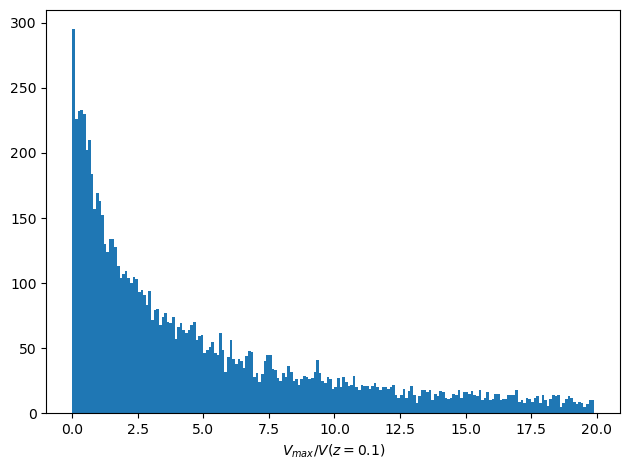

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [7]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [8]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [9]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [10]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [11]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [12]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.364449

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [13]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John

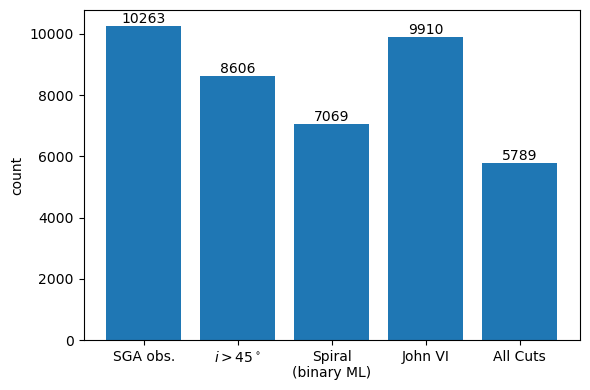

In [14]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [15]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [16]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [17]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [18]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [19]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [20]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [21]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [22]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [23]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [24]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [25]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [26]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [27]:
# zeroptpath = '../cache/SN1A_dist/'
# zeroptpath = '.'
zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/tf_0pt/'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [28]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.isin(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
# zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab['SGA_ID', 'GALAXY', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_SOURCE'].show_in_notebook()

idx,SGA_ID,GALAXY,MU_PRIMARY,MU_SECONDARY,MU_SOURCE
0,40926.0,PGC1068066,--,37.032,SN2017cjv
1,109750.0,PGC007299,36.4634,-1.0,2005hc
2,122260.0,SDSSJ130323.44+271825.0,--,34.9792,2010ai
3,124900.0,PGC1111212,--,36.8581,PS16ayd
4,185629.0,PGC1313612,--,35.825,2007ba
5,236390.0,PGC1093912,--,37.0786,PS16bnz
6,364828.0,PGC1259192,--,35.6231,2006bw
7,431725.0,NGC1699,33.5028,33.5028,2001ep
8,506101.0,PGC1082809,--,37.0786,PS16bnz
9,656304.0,PGC032277,36.1263,36.1263,PS16axi


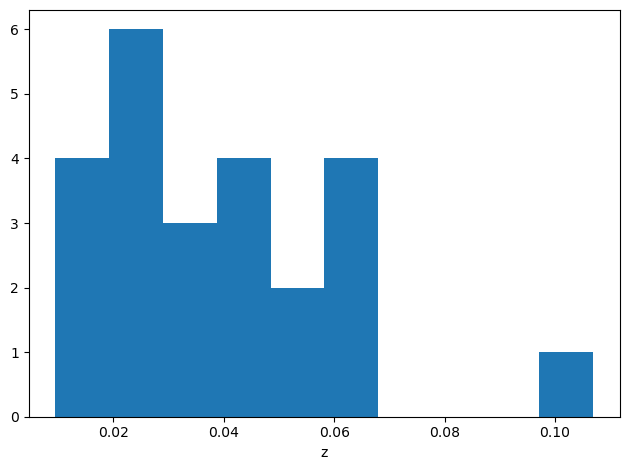

In [29]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [30]:
# Only keep galaxies with a primary SN match
zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [31]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=6>
  1999ac
  2001ep
  2005hc
  500038
 PS15cms
 PS16axi,
 array([1, 1, 1, 1, 1, 1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

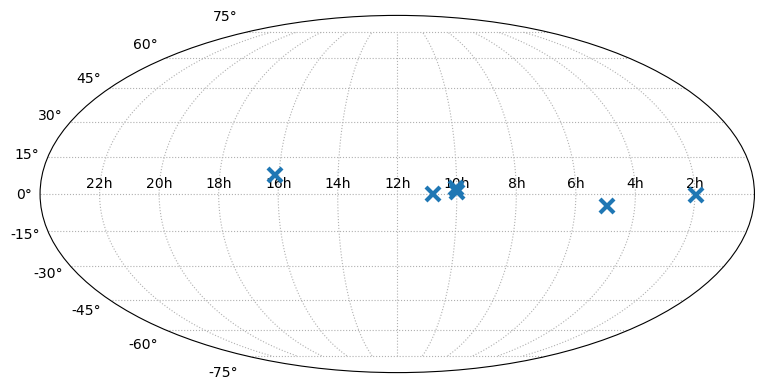

In [32]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

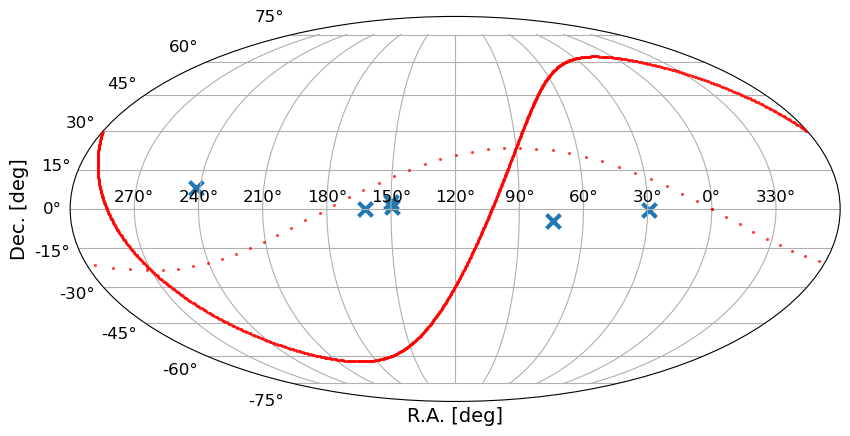

In [33]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color='tab:blue')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_0pt_sky.png', 
# plt.savefig('../../Figures/Y1/iron_0ptPRIMARY_sky.png', 
# plt.savefig('../../../figures/Y1_papers/iron_0ptPRIMARY_sky.png', 
            # dpi=150, 
            # facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [34]:
#- Clean up the distance modulus
# use_primary = ~zeroptab['MU_PRIMARY'].mask
# mu = zeroptab['MU_SECONDARY']
# mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_ERR'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [35]:
# Save this table
# zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', 
#                overwrite=True)

# Access Cluster Catalogs

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_v$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_v$ is the velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [36]:
clusters_T = Table.read('../Tully15-Table3.fits')
clusters_T[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
,,,,deg,deg,[Lsun],km / s,mag,km / s,Mpc,km / s,Msun,
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1.710e+15,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.440,707,5.290e+14,1.00
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.520,746,6.230e+14,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1.770e+15,2.26
1,100005,61,36487,92.0255,-10.4950,12.78,6987,34.22,707,1.560,766,6.730e+14,1.58


In [37]:
# Convert Tully's central cluster velocities to heliocentric frame (to match the DESI redshift frame)
cls_coords = SkyCoord(clusters_T['SGLON'], clusters_T['SGLAT'], unit='deg', frame='supergalactic').icrs
z_hel = convert_z_frame(clusters_T['<Vcmba>']/c.c.to('km/s'), cls_coords.ra.deg, cls_coords.dec.deg, corrtype='-full')
clusters_T['HRV'] = z_hel*c_kms
clusters_T[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF,HRV
,,,,deg,deg,[Lsun],km / s,mag,km / s,Mpc,km / s,Msun,,
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1.710e+15,1.65,7056.410096941048
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.440,707,5.290e+14,1.00,1161.7922735623201
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.520,746,6.230e+14,1.12,3587.4600297854763
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1.770e+15,2.26,9399.655364870352
1,100005,61,36487,92.0255,-10.4950,12.78,6987,34.22,707,1.560,766,6.730e+14,1.58,6653.443936152573


In [38]:
clusters_K = Table.read('../Kourkchi17-Table2.fits.gz')
clusters_K[:5]

PGC1,PGC1+,Nm,GLON,GLAT,SGLON,SGLAT,Ksmag,logK,HRV,VLS,Nd,Dist,e_Dist,sigmaL,sigmaV,R2t,Rg,logMK,logMd
,,,deg,deg,deg,deg,mag,[Lsun],km / s,km / s,,Mpc,%,km / s,km / s,Mpc,Mpc,[Msun],[Msun]
int32,int32,int16,float64,float64,float64,float64,float64,float64,int16,int16,int16,float64,int16,int16,int16,float64,float64,float64,float64
43296,43296,191,302.2241,21.6465,156.3251,-11.5819,4.61,12.71,3407,3142,59,36.96,3,595,800,1.612,0.893,14.624,14.717
46618,43296,30,307.8738,19.2865,159.6426,-6.8008,6.07,12.11,3340,3086,5,37.57,7,350,307,0.950,0.745,13.936,13.808
45174,43296,34,306.0424,32.5707,146.1941,-6.0422,6.42,11.96,3292,3059,4,44.03,8,307,300,0.833,0.693,13.764,13.756
40498,43296,24,297.5648,23.0823,153.9019,-15.4648,6.48,11.92,3258,2986,4,28.45,6,296,170,0.801,0.607,13.713,13.207
43557,43296,22,302.9333,36.4075,141.8602,-7.7062,6.82,11.81,3296,3066,7,39.89,8,267,163,0.724,0.428,13.582,13.017


In [39]:
# Rename columns to match Tully's catalog
clusters_K['Nm'].name = 'Nmb'
clusters_K['sigmaL'].name = 'sigP'
clusters_K['sigmaV'].name = 'sigV'

# Convert from distance to distance modulus
clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25

# Define NestID
clusters_K['Nest'] = np.char.add('3', clusters_K['PGC1'].astype('str')).astype('int')

/tmp/ipykernel_518567/1224197170.py:7: RuntimeWarning: divide by zero encountered in log10
  clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25


## Combine the two cluster catalogs

We are going to keep the properties from Kourkchi's catalog when possible (as it is an updated version of Tully's).

In [40]:
# Determine which clusters in Kourkchi's table are already in Tully's
K_keep = np.ones(len(clusters_T), dtype=bool)

for i in range(len(clusters_K)):
    K_keep = K_keep & (clusters_T['PGC1'] != clusters_K['PGC1'][i])

clusters_all = vstack([clusters_T[K_keep], clusters_K])

clusters = clusters_all['Nest', 'Nmb', 'PGC1', 'SGLON', 'SGLAT', 'DM', 'sigV', 'sigP', 'R2t', 'HRV'][clusters_all['Nmb'] >= 5]
len(clusters)

1321

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015) and Kourkchi et al. (2017).

Loop through the data and keep only clusters where DESI has at least 10 galaxies with TF measurements passing all quality cuts.

In [41]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

In [42]:
sga_clusters = {}
# m_dwarf_clusters = {}
n_cluster_min = 5

#- Convert distance moduli to velocities [in km/s]
velos = 100 * 10**(0.2*(clusters['DM'] - 25)) / (1 + clusters['HRV']/c_kms)
# Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0

# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    nest_id = clusters['Nest'][i]
    
    #- Sky coordinates of cluster
    cls_coord = SkyCoord(clusters['SGLON'][i], 
                         clusters['SGLAT'][i], 
                         unit='deg', 
                         frame='supergalactic')

    #- Cluster turnaround radius, velocity dispersion, and distance modulus
    R2t = clusters['R2t'][i]
    # sigP = clusters['sigP'][i]
    sigV = clusters['sigV'][i]
    velo = velos[i]

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigV) & (z_sga_desi*c_kms < velo + 3*sigV)

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
        # m_dwarf_clusters[nest_id] = -17 + mu

/tmp/ipykernel_518567/3315083277.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
/tmp/ipykernel_518567/3315083277.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian
100%|██████████| 1321/1321 [00:11<00:00, 113.15it/s]


In [43]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100046   5 galaxies
 2  100058   9 galaxies
 3  100067  12 galaxies
 4  100081   7 galaxies
 5  100102   6 galaxies
 6  100168   5 galaxies
 7  100221  12 galaxies
 8  100237   5 galaxies
 9  100282   6 galaxies
10  100300   7 galaxies
11  200023   7 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

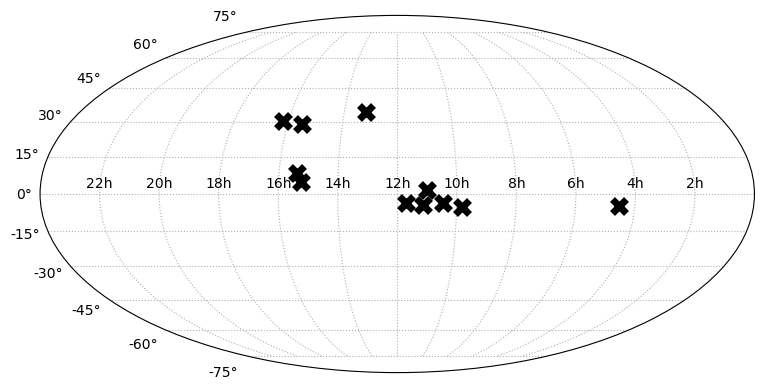

In [44]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);

In [45]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [46]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_hrv = clusters['HRV'][idx][0]
    # cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = 100 * 10**(0.2*(cluster_mu - 25)) / (1 + cluster_hrv/c_kms)
    cluster_sigma = clusters['sigV'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_2 = np.arctan(2*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_2)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(inner)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles='solid')

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles='solid')

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

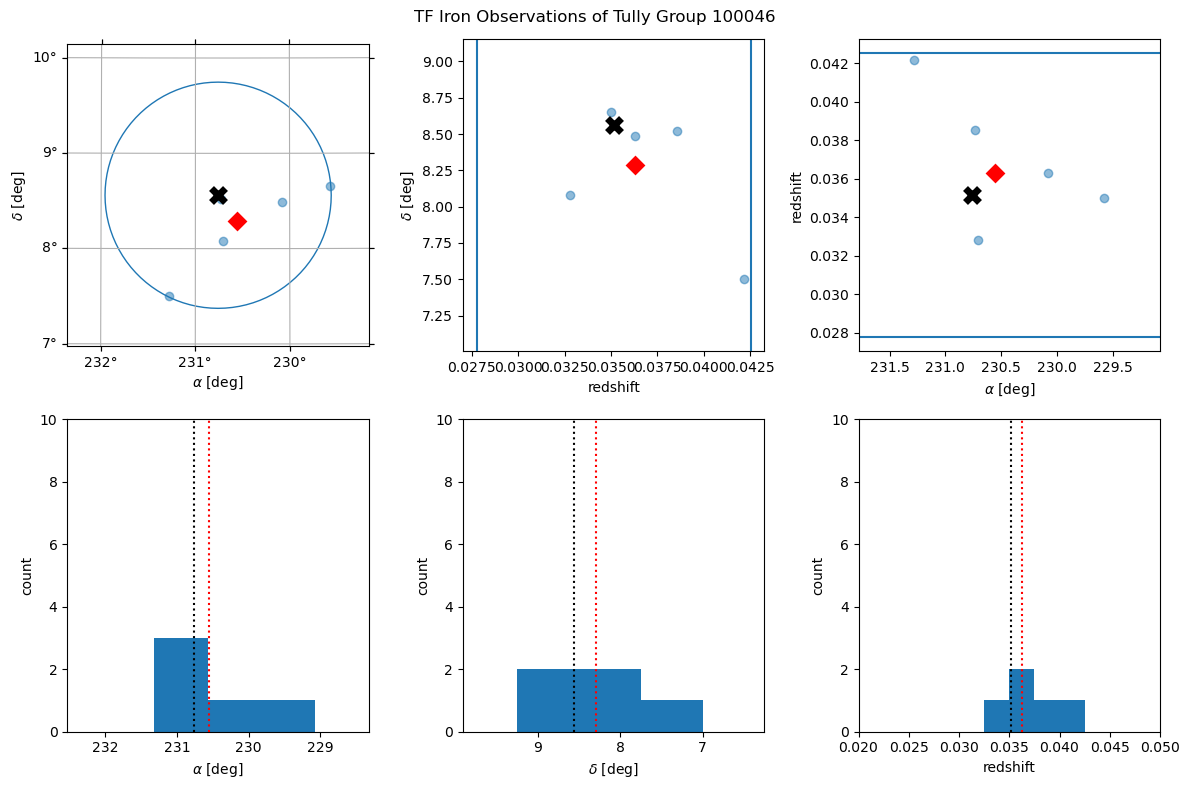

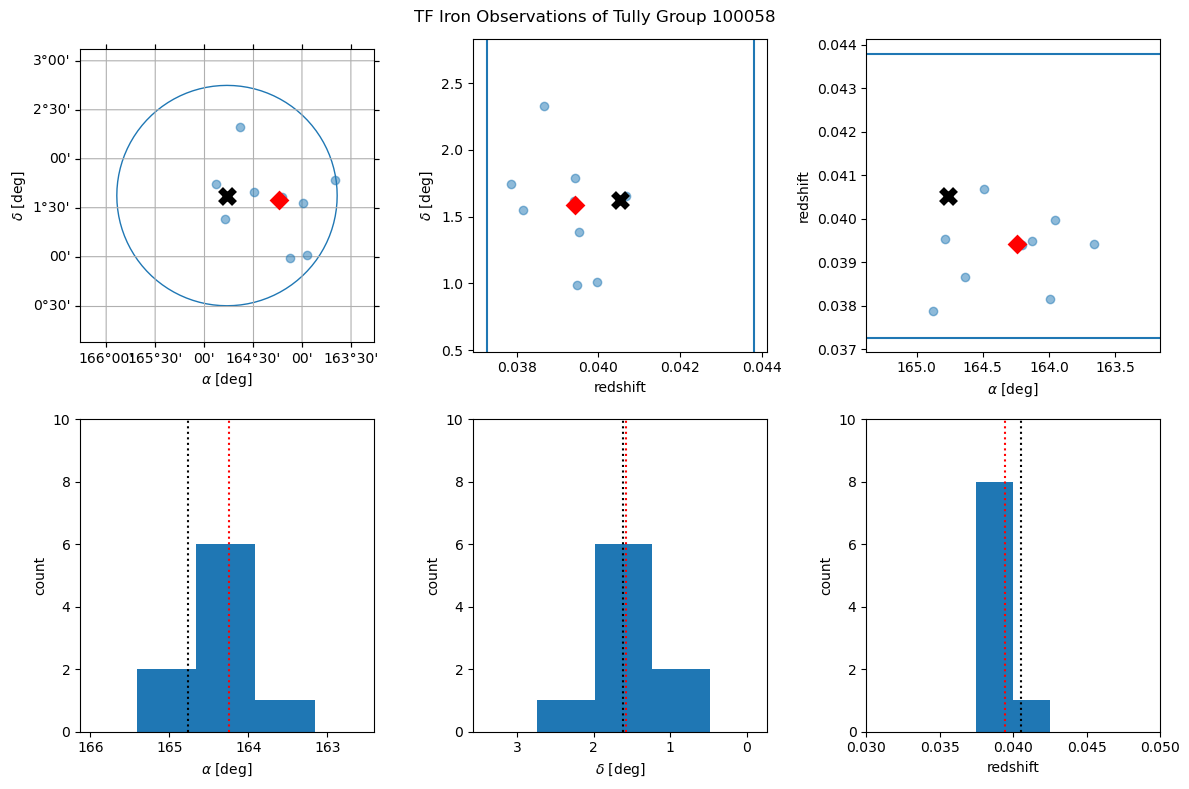

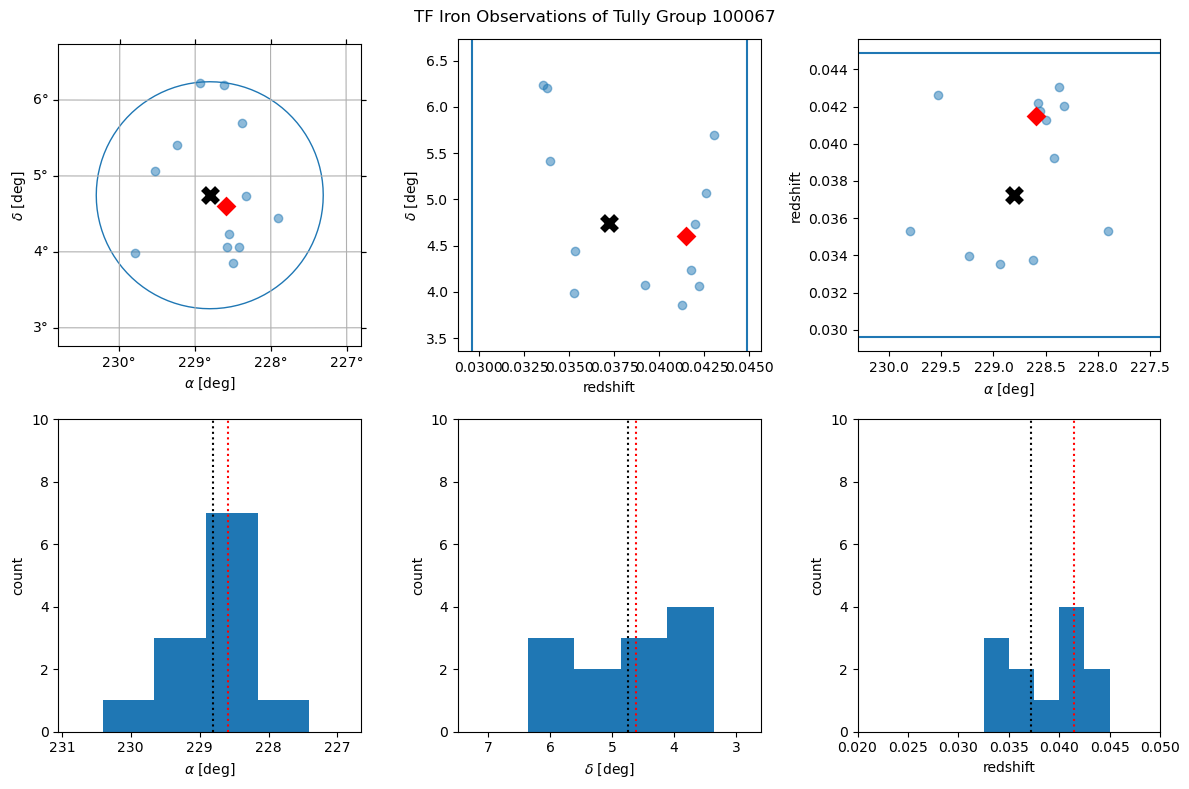

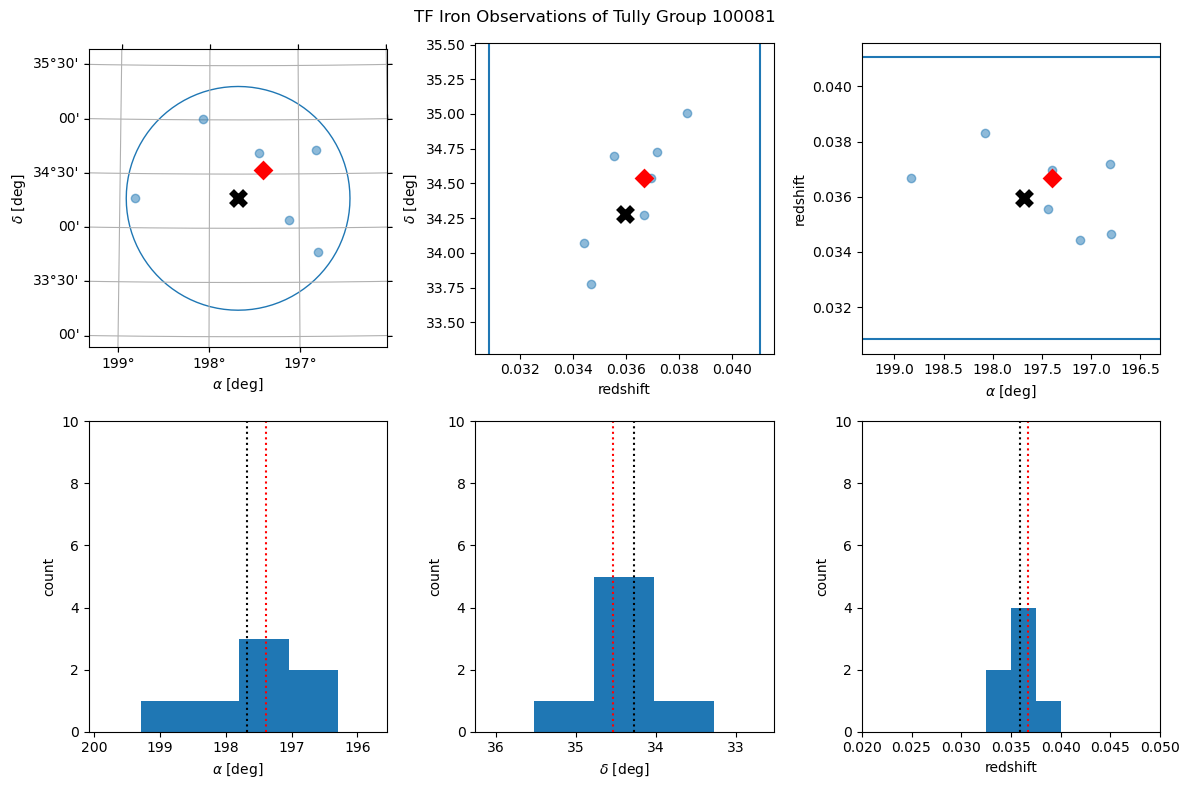

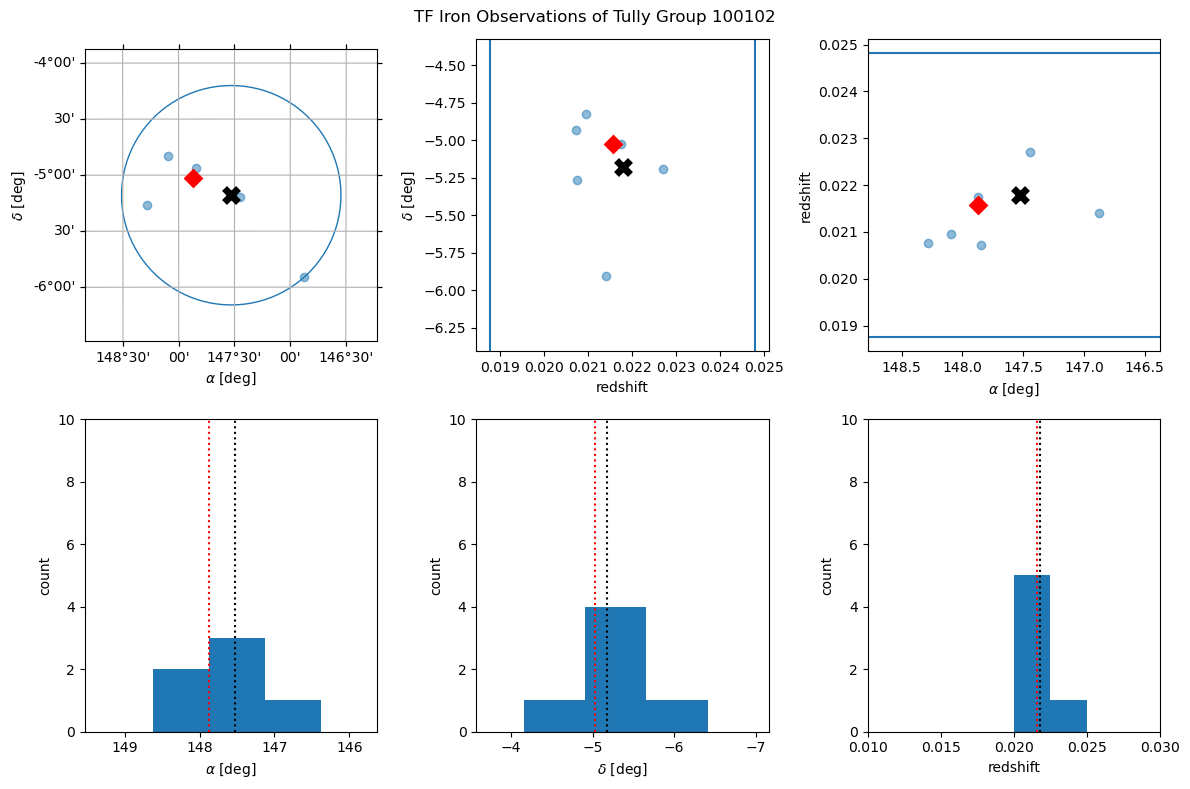

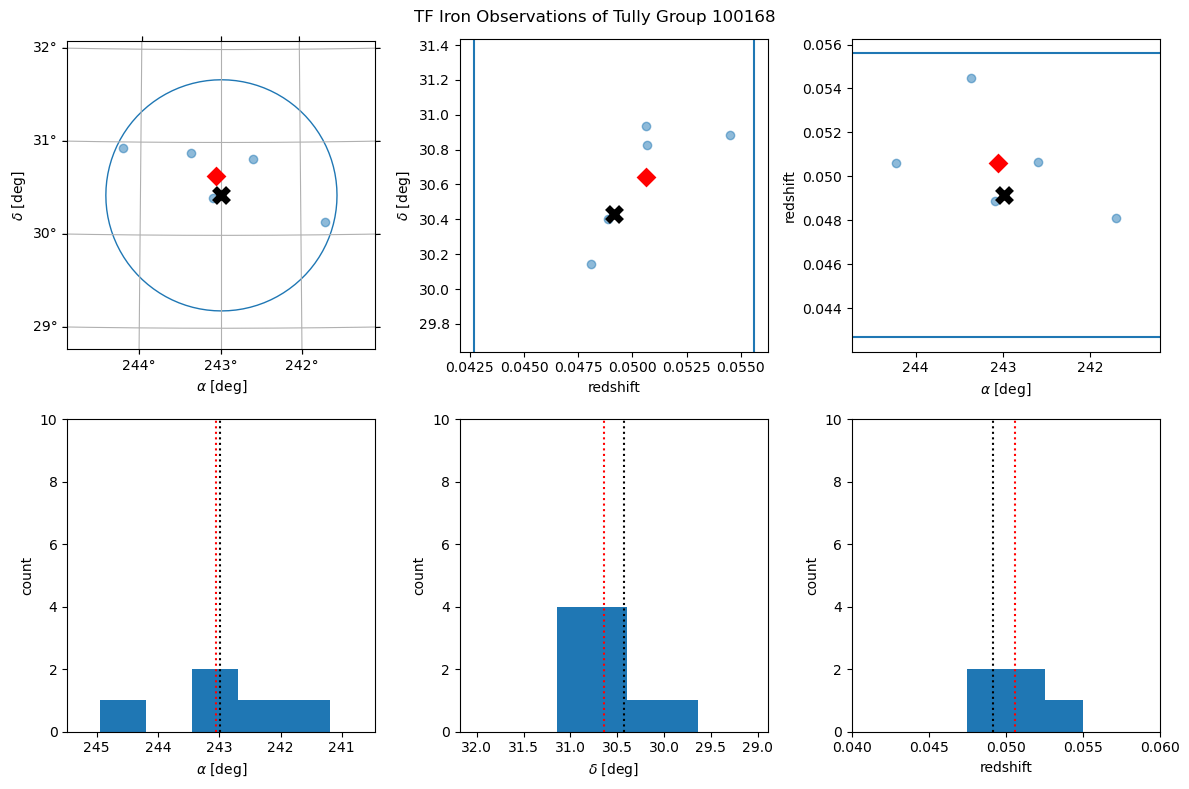

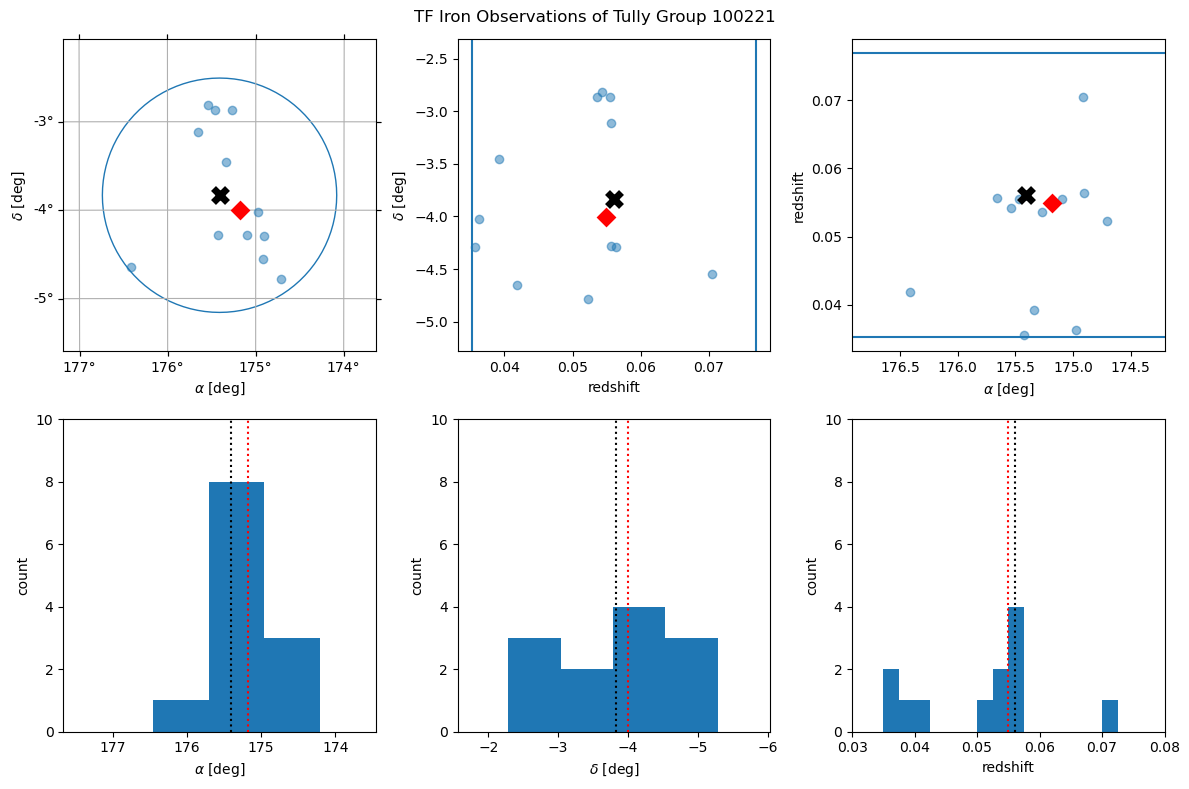

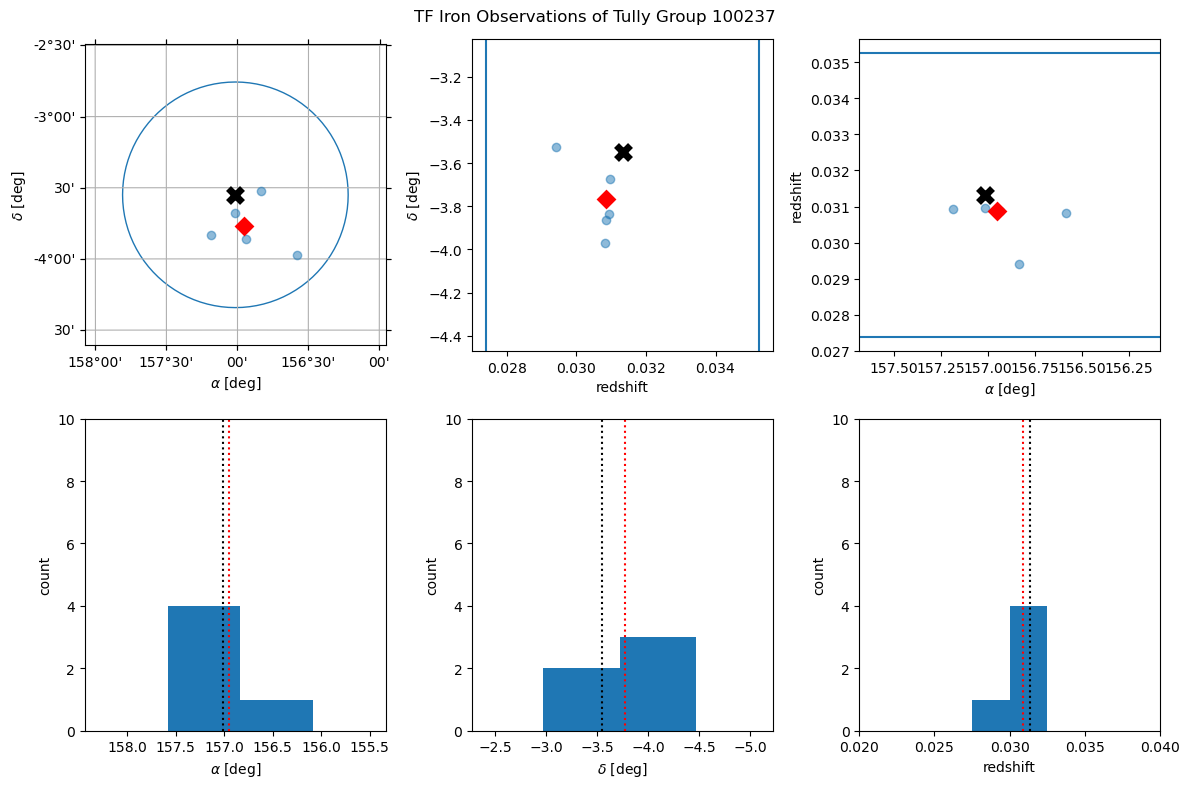

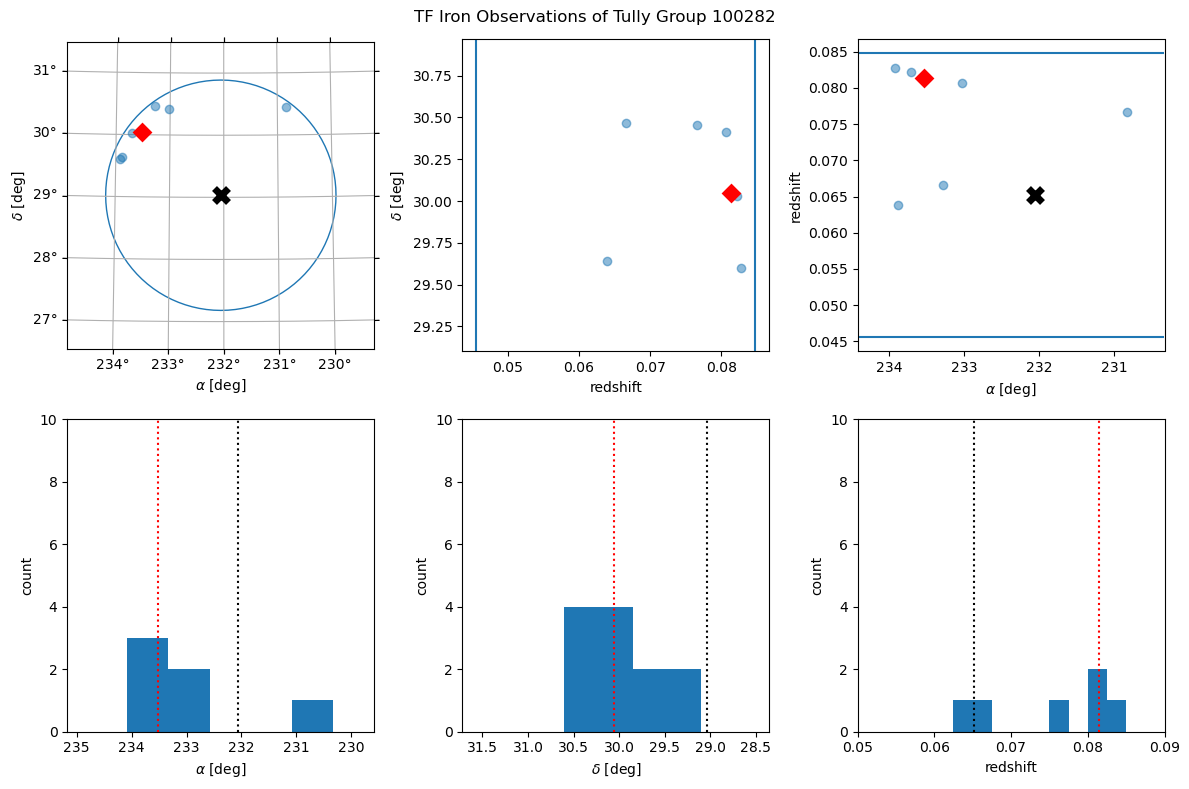

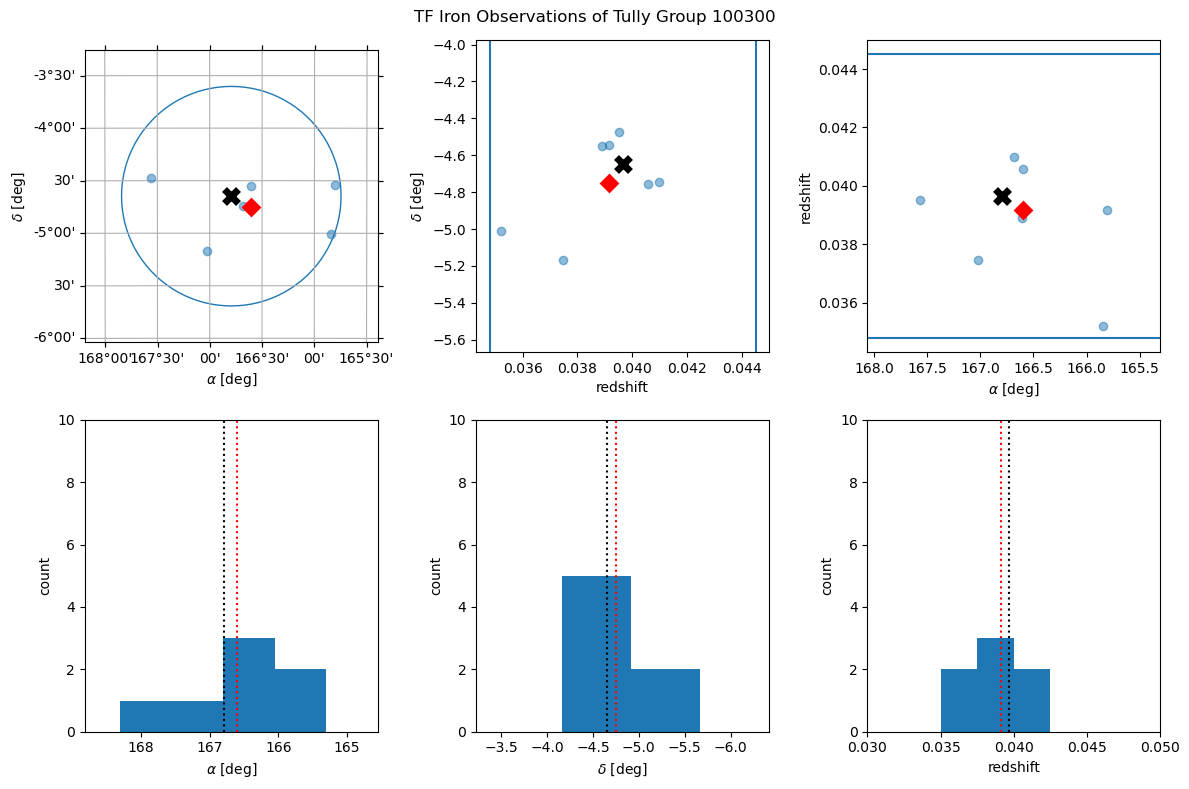

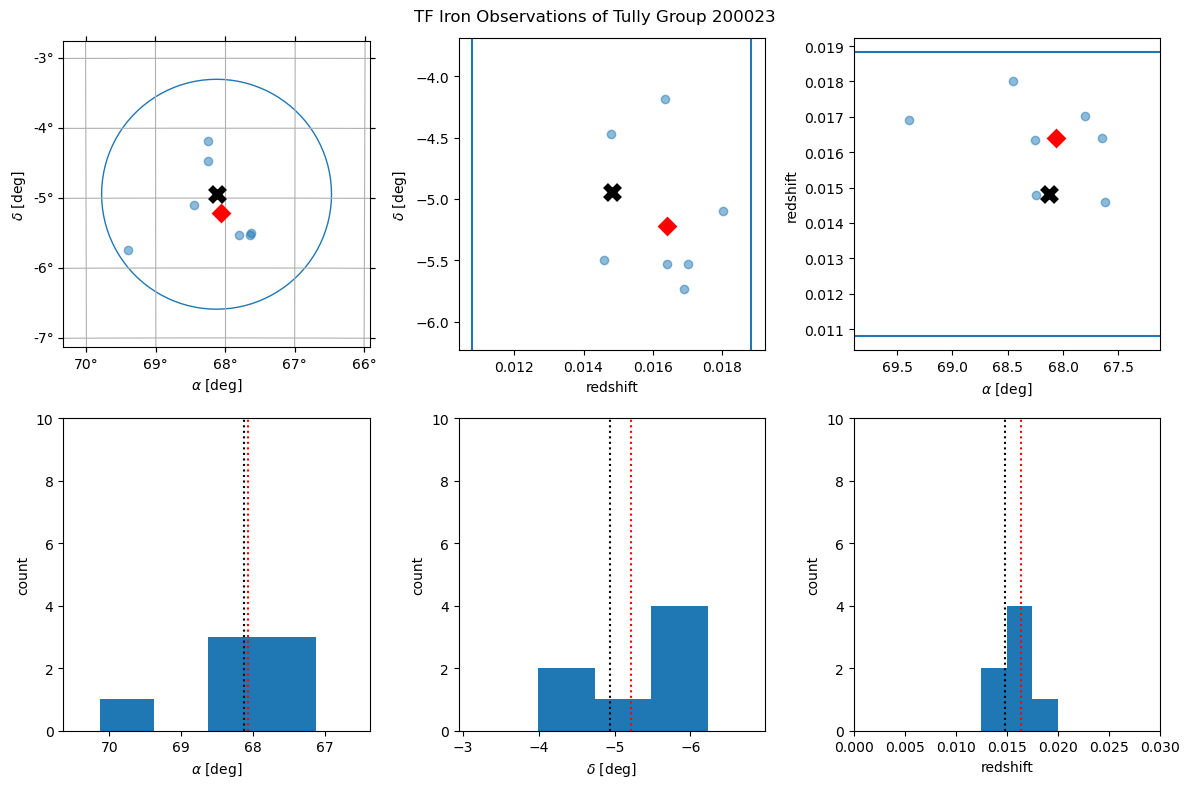

In [49]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_V$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_V$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_V < 1$
2. $\Delta\theta / R_{2t} < 1$

100046       339.936 km/s     737.000 km/s       0.461       0.338 deg       0.791 deg       0.285
100058       333.839 km/s     326.000 km/s       1.024       0.528 deg       0.750 deg       0.469
100067      1282.703 km/s     763.000 km/s       1.681       0.256 deg       0.997 deg       0.171
100081       220.970 km/s     511.000 km/s       0.432       0.350 deg       0.688 deg       0.339
100102        61.734 km/s     303.000 km/s       0.204       0.373 deg       0.653 deg       0.381
100168       444.089 km/s     646.000 km/s       0.687       0.218 deg       0.830 deg       0.176
100221       358.841 km/s    2083.000 km/s       0.172       0.286 deg       0.884 deg       0.216
100237       138.668 km/s     393.000 km/s       0.353       0.226 deg       0.528 deg       0.285
100282      4863.640 km/s    1960.000 km/s       2.481       1.637 deg       1.236 deg       0.883
100300       145.321 km/s     485.000 km/s       0.300       0.218 deg       0.697 deg       0.208
200023    

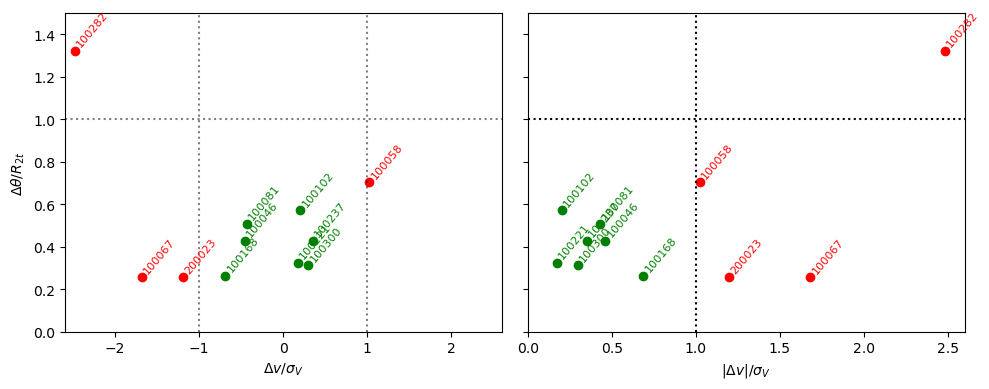

In [47]:
keep_cluster = []
dv_sigmaV = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_v = 100 * 10**(0.2*(clusters['DM'][idx][0] - 25)) / (1 + clusters['HRV'][idx][0]/c_kms)
    cluster_sigma = clusters['sigV'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigV = delta_v / cluster_sigma
    dv_sigmaV.append(_dv_sigV)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaV = np.asarray(dv_sigmaV)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1

select = (np.abs(dv_sigmaV) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaV[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaV[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaV[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaV[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_V$',
       xlim=(-2.6, 2.6),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,1.5))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaV[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaV[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaV[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaV[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_V$',
       xlim=(0, 2.6));

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters-1p5R2t_selection_binaryMLupdated_20250606.png', 
#             dpi=150, 
#             facecolor='none')

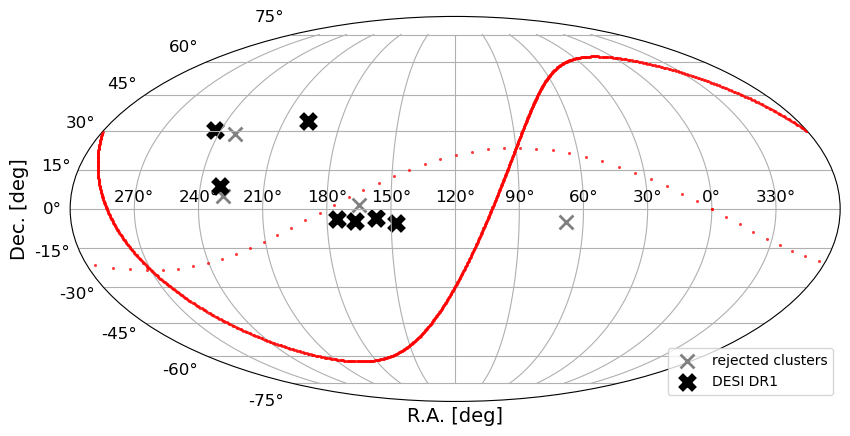

In [48]:
nest_ids = np.asarray(list(sga_clusters.keys()))
good_idx = np.in1d(clusters['Nest'], nest_ids[select])
bad_idx = np.in1d(clusters['Nest'], nest_ids[~select])
good_cluster_coords = SkyCoord(clusters['SGLON'][good_idx], clusters['SGLAT'][good_idx], unit='deg', frame='supergalactic')
bad_cluster_coords = SkyCoord(clusters['SGLON'][bad_idx], clusters['SGLAT'][bad_idx], unit='deg', frame='supergalactic')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected clusters')
ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_clusters-1p5R2t_AnthonyUpdates_sky.png', 
#             dpi=150, 
#             facecolor='none')

In [49]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100046   5 galaxies  Y
 2  100058   9 galaxies  N
 3  100067  12 galaxies  N
 4  100081   7 galaxies  Y
 5  100102   6 galaxies  Y
 6  100168   5 galaxies  Y
 7  100221  12 galaxies  Y
 8  100237   5 galaxies  Y
 9  100282   6 galaxies  N
10  100300   7 galaxies  Y
11  200023   7 galaxies  N


## Plot Galaxy Clusters that Failed the Selection

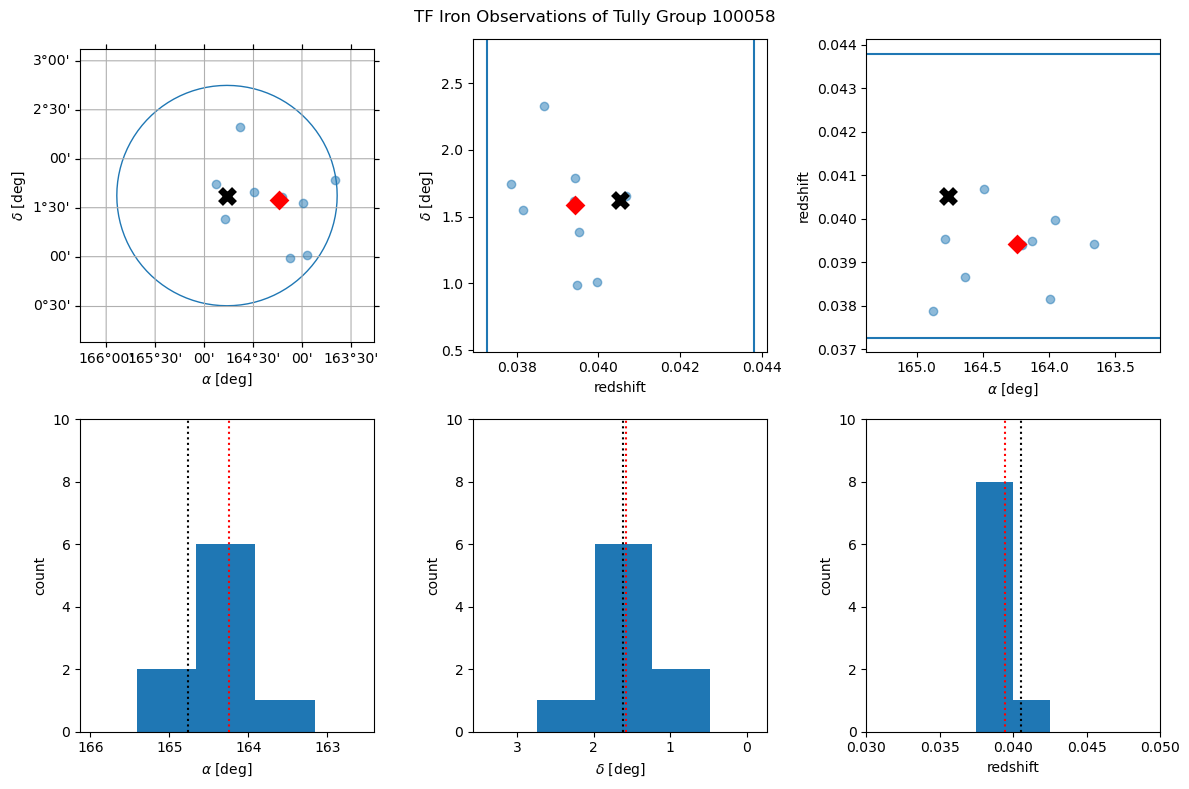

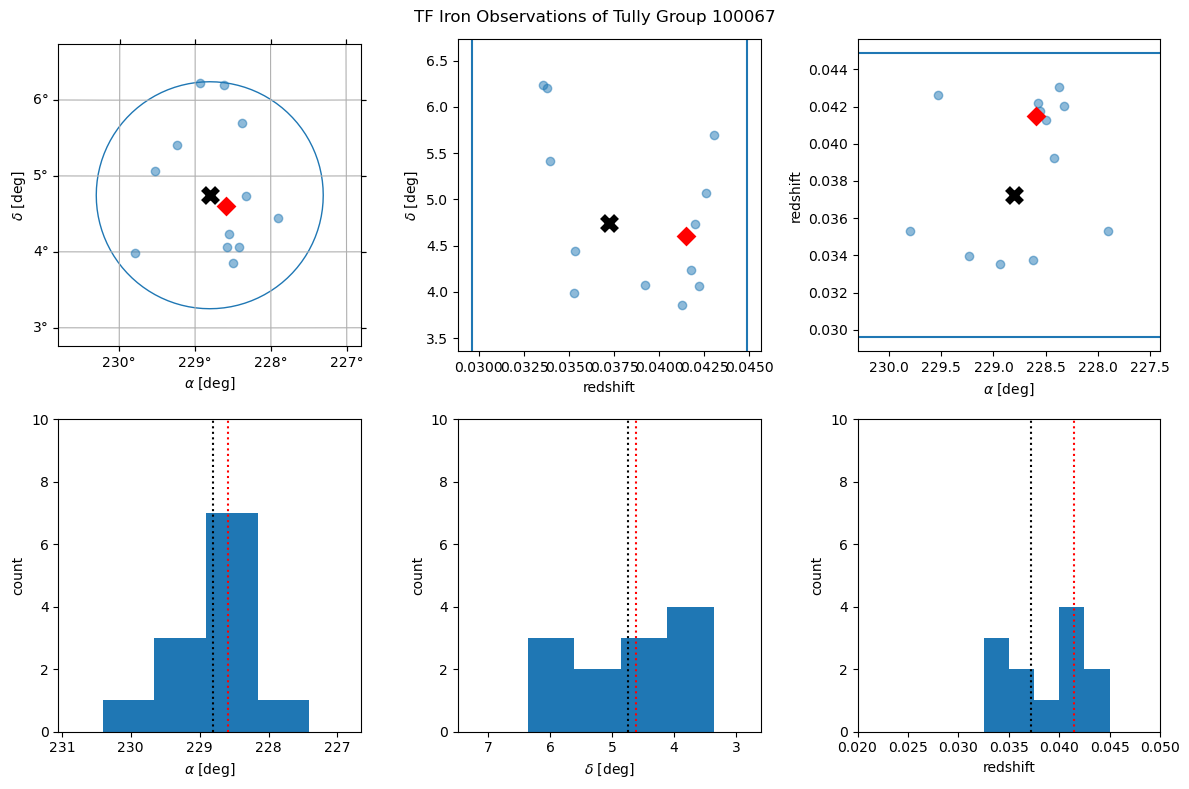

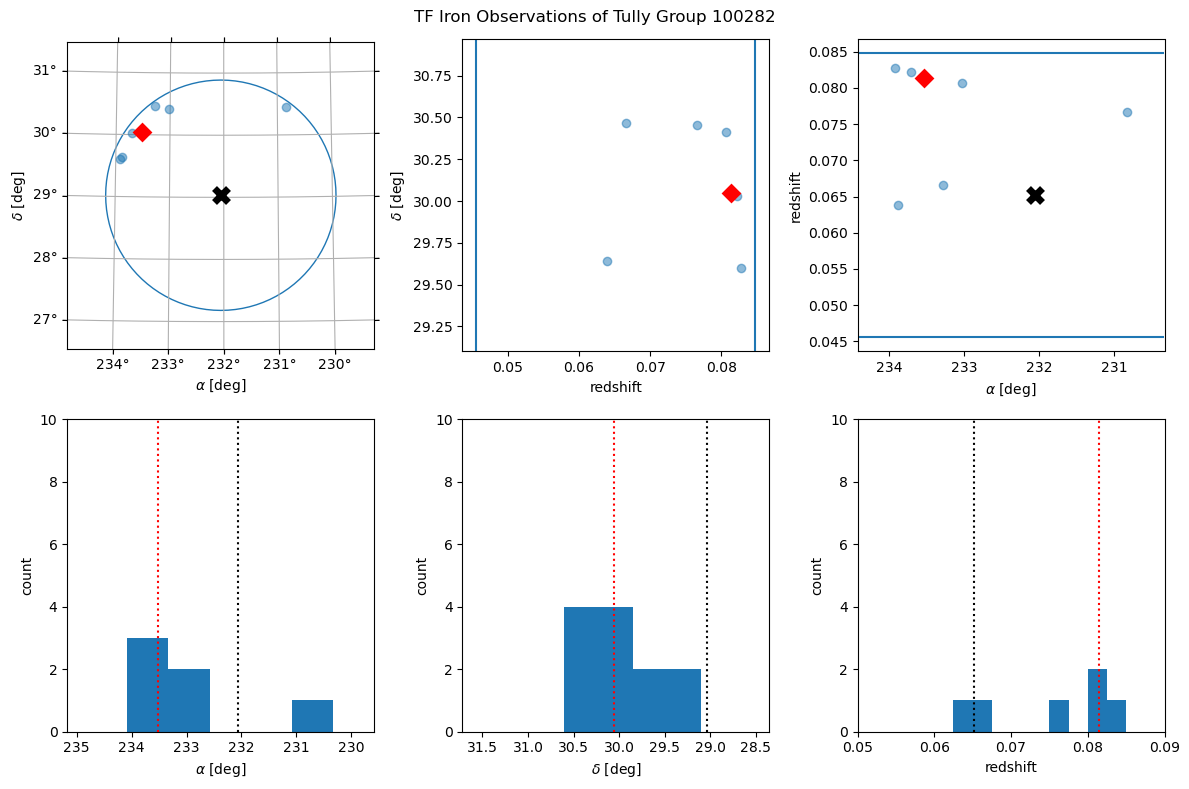

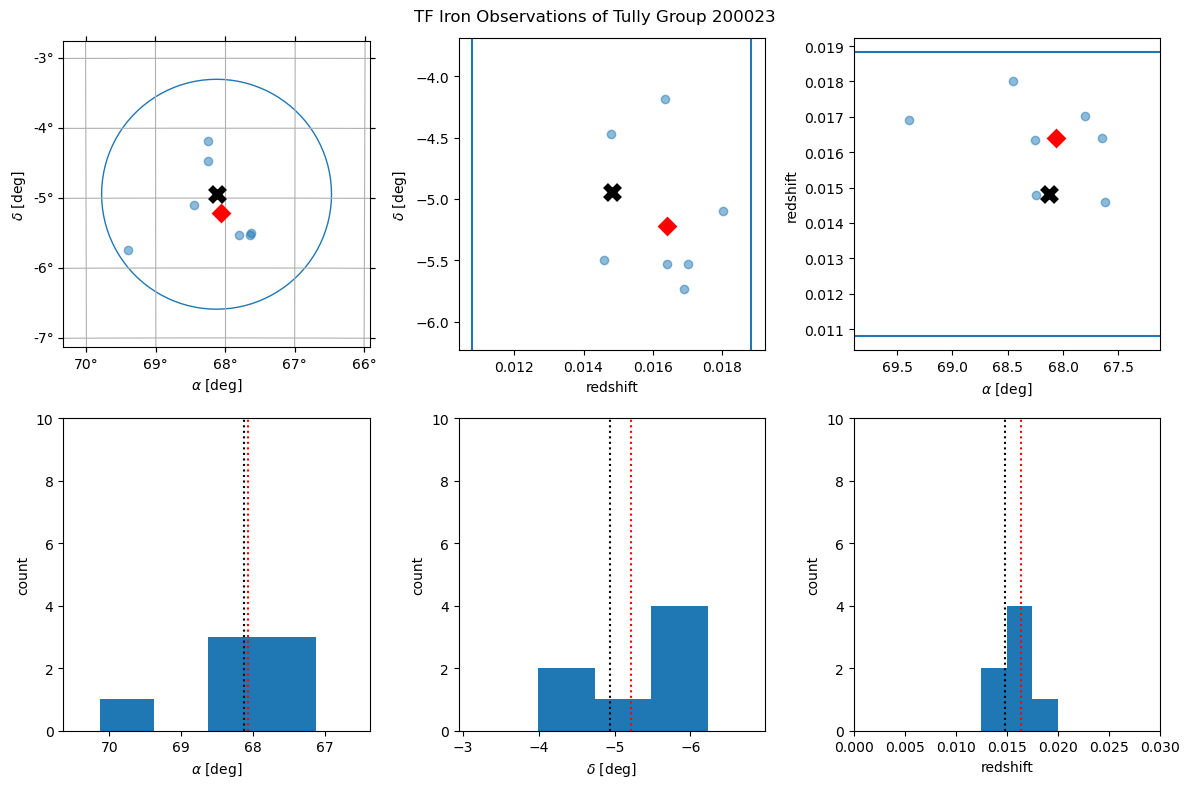

In [61]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id]);
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

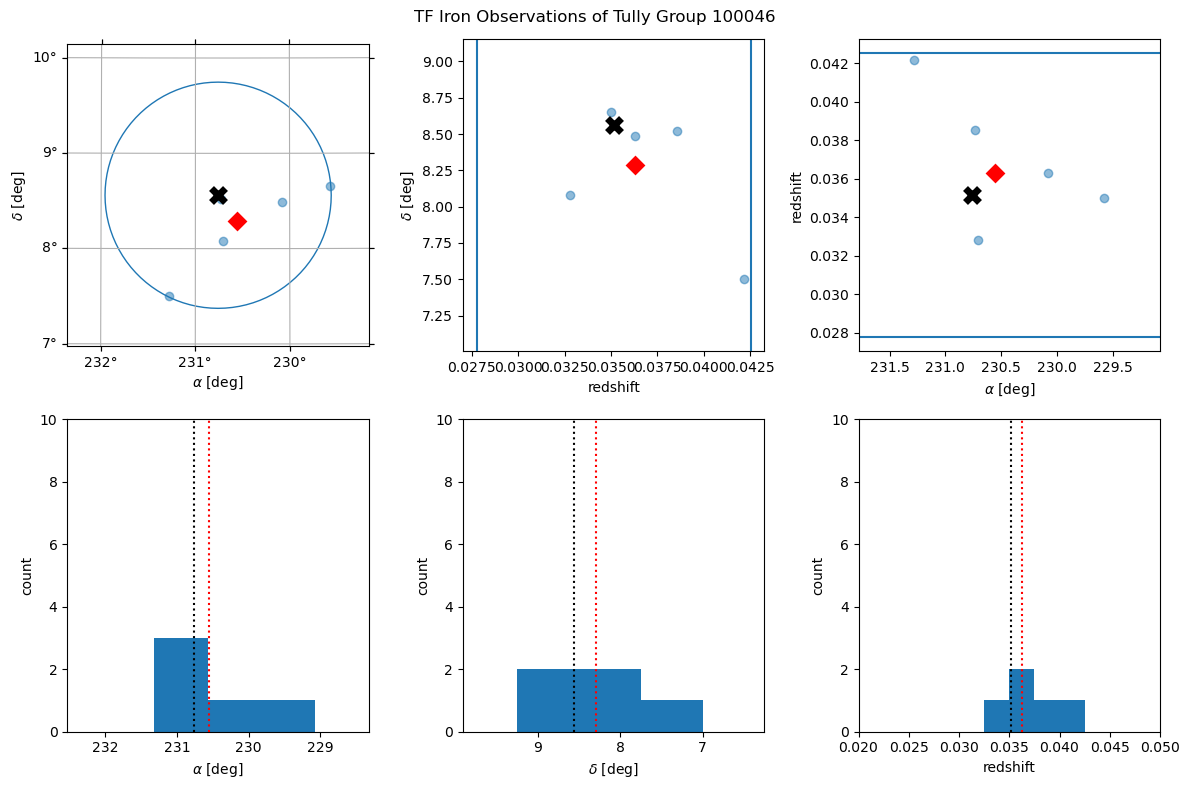

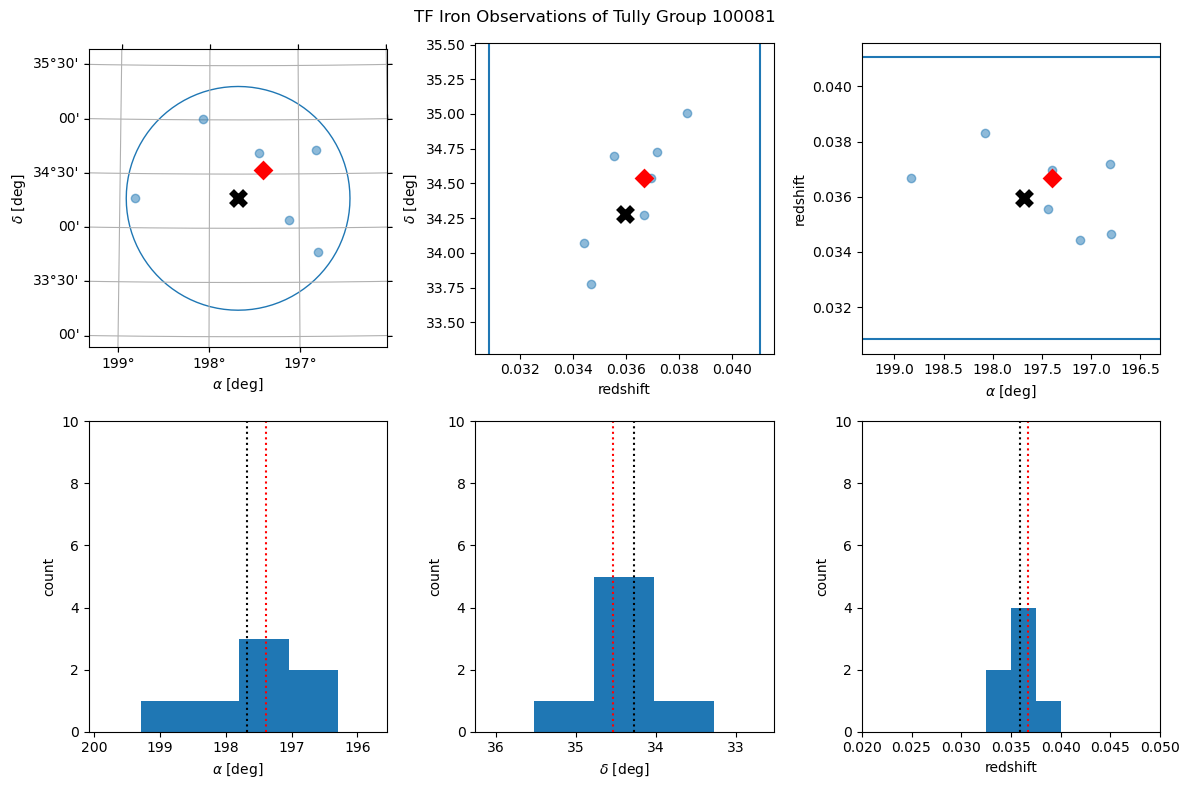

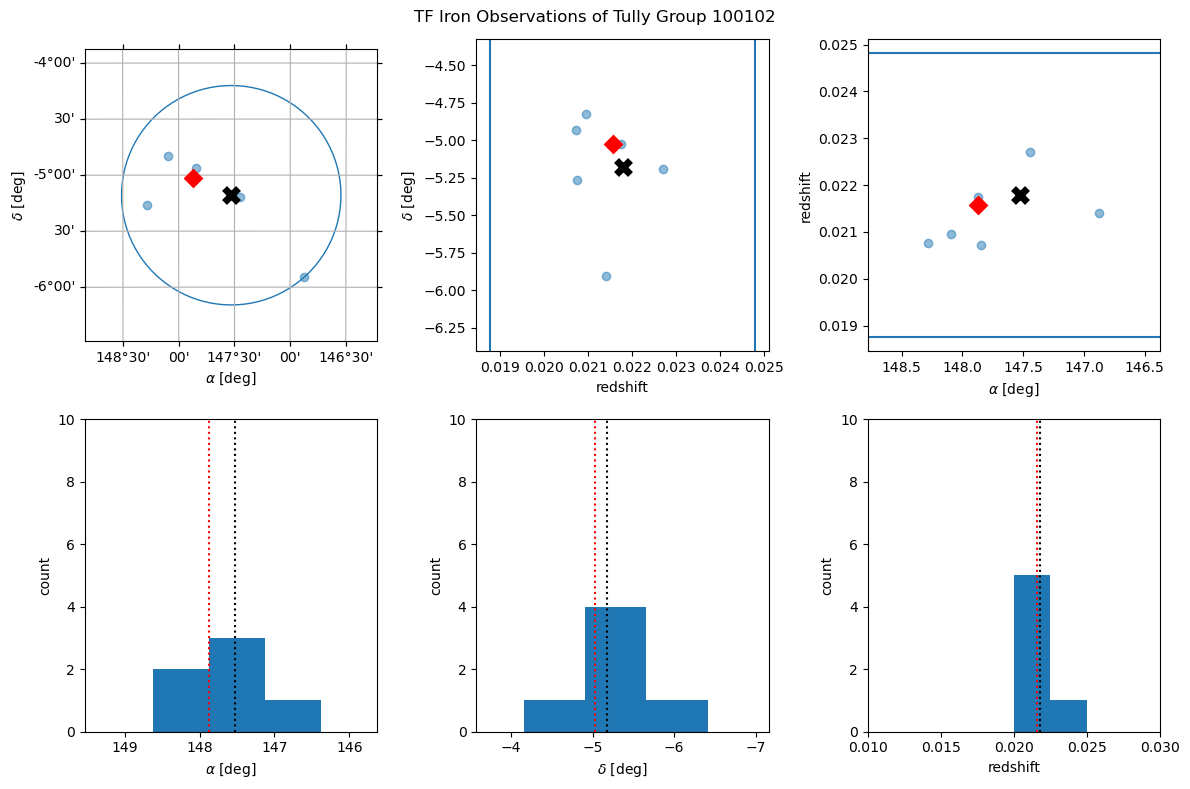

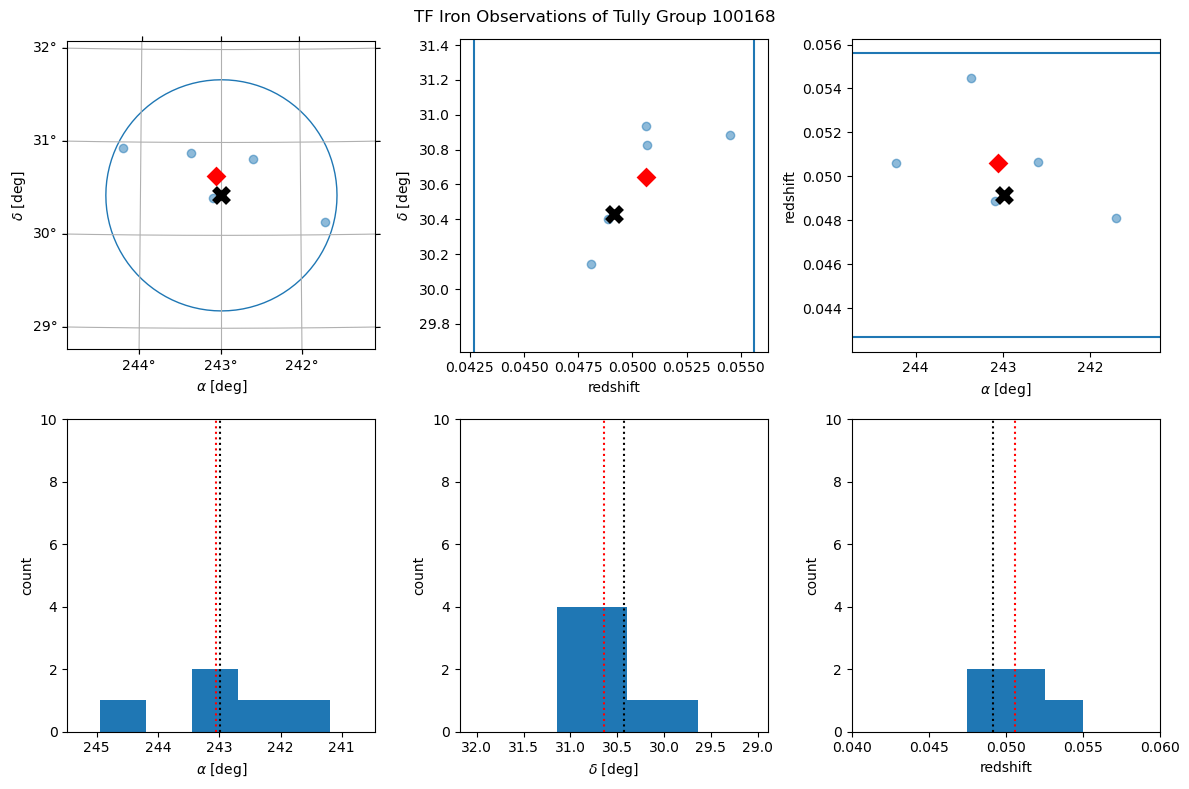

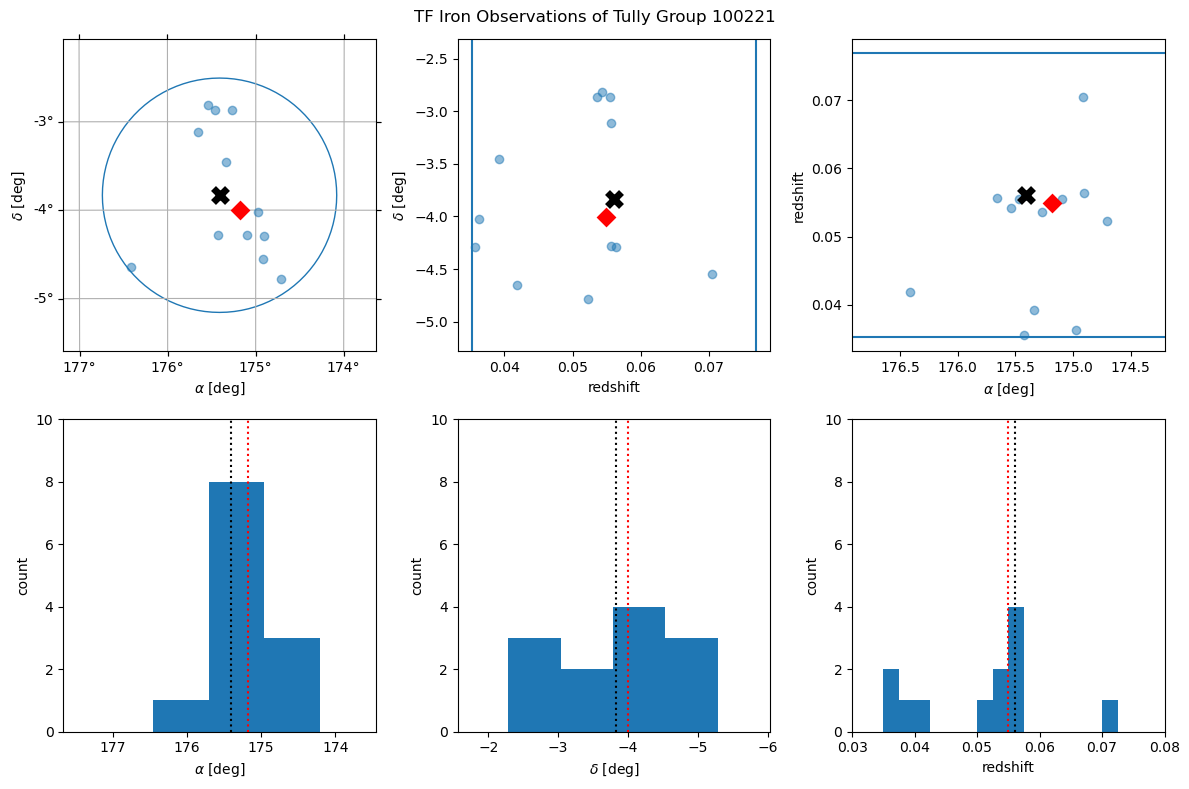

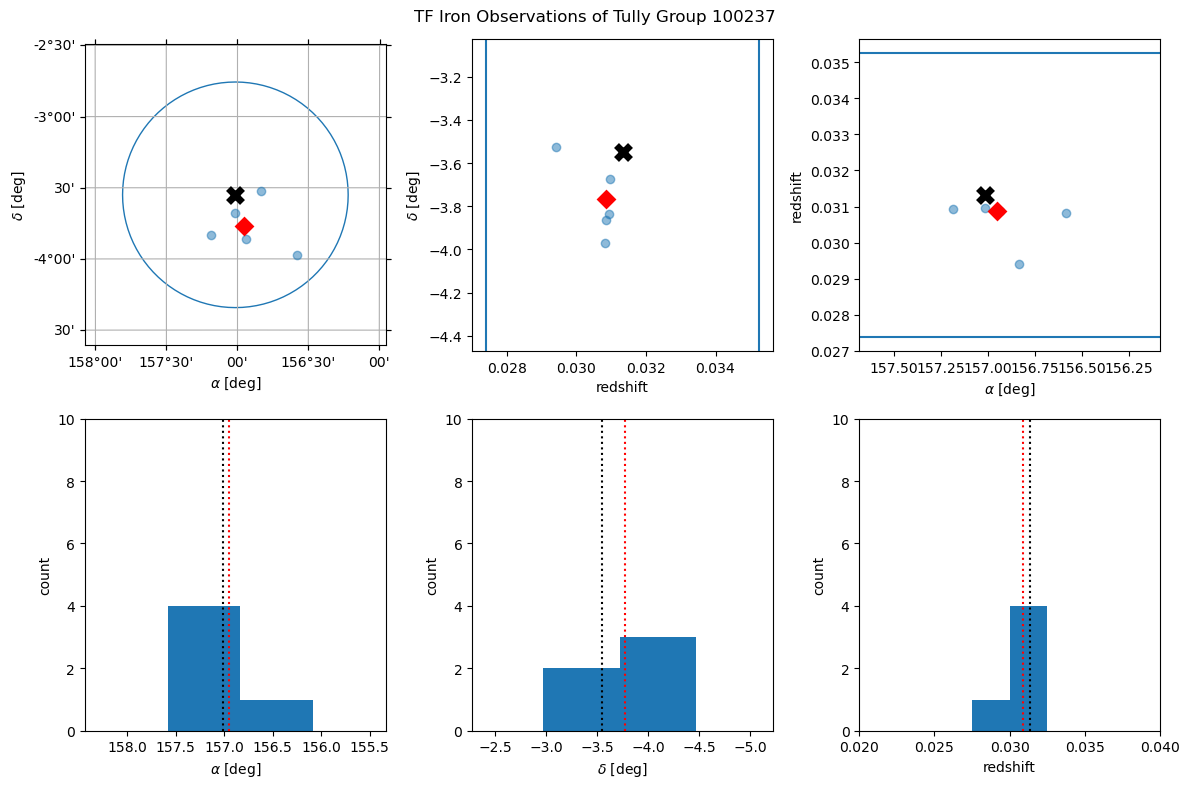

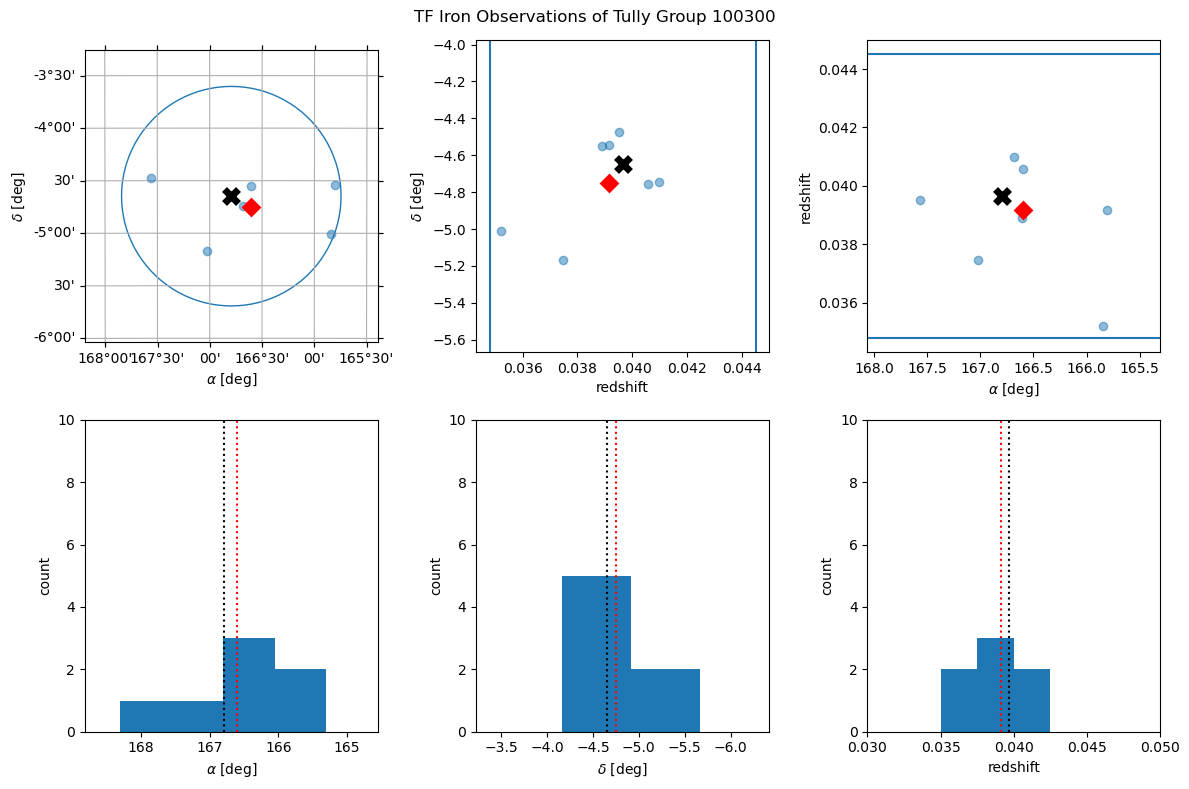

In [62]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id]);
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [50]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

CLUSTER_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64
100046,451964.0,14.253494208389894,0.06053078153234674,155.08650022463794,10.092820729650098
100046,1003623.0,16.348455067649482,0.0641390520045119,96.23577683909735,7.88236504782934
100046,1193976.0,16.37959211193025,0.1394908037521029,76.79878666868261,9.97360440416998
100046,1199210.0,15.802980119129643,0.11130073750972012,100.93066086279542,14.68599318997392
100046,1304279.0,14.83960438190028,0.07134833581846814,108.71293672394118,31.106179034950838
100081,306789.0,16.022222957533412,0.1440173159704082,58.51966828386689,7.345647360102924
100081,365639.0,16.878736086580062,0.09907094410389153,89.50678762918183,5.203413495223901
100081,647701.0,16.293413004085046,0.1285835279520219,73.12187787959333,7.156586394619202
100081,733068.0,15.258742465215363,0.13901227957236037,111.64906645217219,7.594099628261271


In [51]:
# Are there any galaxies which have been matched to multiple clusters?
unique, counts = np.unique(caltab['SGA_ID'], return_counts=True)

print(len(unique[counts > 1]), 'galaxies assigned to more than one cluster')

0 galaxies assigned to more than one cluster


In [52]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
'''
for cluster in np.unique(caltab['CLUSTER_ID']):
    output_filename = 'output_' + str(cluster) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)
''';

In [66]:
rejtab

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,JOHN_VI,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,,,,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,str10,str6,float64,float64,float64,float64,float64,float64,int64
243591.0,SGA-2020 243591,PGC083375,83375,164.12500500000002,0.9878077,Sab,156.32,0.3758374,0.6501297,0.039434277,23.408482,16.905,False,LEDA-20181114,87743,PGC083375,1,True,164.12500500000002,0.9878077,0.3758374,1641p010,164.12500740893083,0.9877918896411213,0.6276506,SB26,157.81944,0.5407116,164.12494921373772,0.9878474850355439,14.366872,5.598159,5.4044905,5.4211454,6.7757277,8.219722,9.582329,10.853714,12.179372,13.70163,15.313066,17.055748,18.82952,17.028368,16.266712,15.724569,16.856554,16.100956,15.559044,16.7552,16.001934,15.457424,16.694195,15.941648,15.394356,16.651745,15.899607,15.354319,16.617386,15.867476,15.3206215,16.592546,15.844793,15.295227,16.572548,15.826813,15.276844,16.559168,15.8135,15.264713,0.04315565,0.05888833,0.056417733,0.057596926,0.07347442,0.066764794,0.10122966,0.13346666,0.08933271,0.0116646355,0.011831591,0.011271127,0.011430502,0.011460868,0.010987064,0.011079548,0.011084489,0.010645563,0.0107388925,0.0107371835,0.0103317695,0.010443177,0.010446111,0.

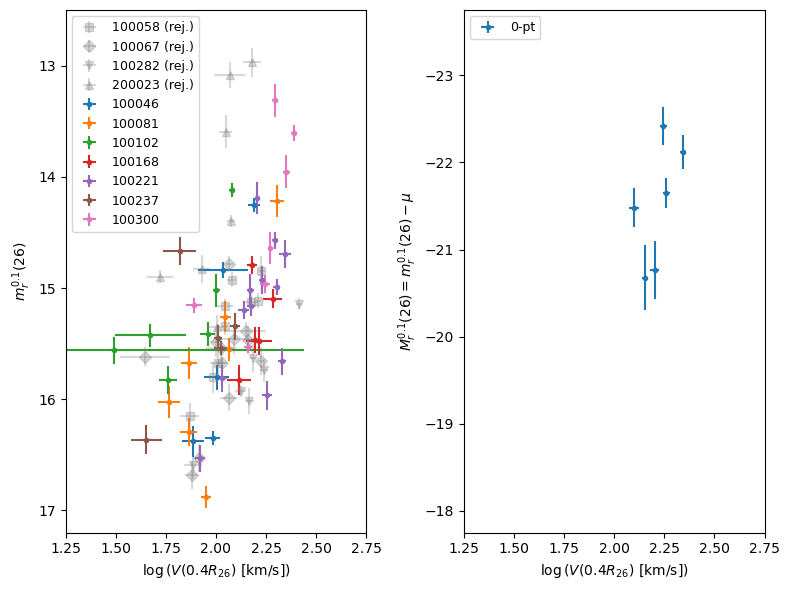

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
_cluster_ids = np.unique(rejtab['CLUSTER_ID'])
markers = 'sDv^<>'
for j, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[17.2, 12.5],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_ERR'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_ERR'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_1p5R2t_0pt_binaryMLupdated_20250606.png', 
#             dpi=150, 
#             facecolor='none');

# Apply the Joint TFR Fit

In [54]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_ERR'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_ERR'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_cluster]))

logV0 = 2.138186873260832


## Multiline Fit using HyperFit

In [55]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -453.5903932543736
     jac: array([ 0.00230784, -0.00220552,  0.0024329 , -0.00131877,  0.0075147 ,
        0.00446789, -0.00043201,  0.00080718,  0.00121076,  0.00215437])
 message: 'Optimization terminated successfully.'
    nfev: 22149
     nit: 146
 success: True
       x: array([ -7.17514691, -20.97509259,  14.76683772,  14.64094895,
        13.68665935,  15.7289017 ,  15.66688697,  14.19009081,
        15.14245556,   0.54962814])
Ndim: 10 8


100%|██████████| 1000/1000 [00:20<00:00, 47.77it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [56.17490699 56.57045084 56.13531496 53.58056802 56.96145806 54.93641609
 48.6683752  61.74010088 61.58866227 53.90547218] / 3087.0050437813006


100%|██████████| 1000/1000 [00:23<00:00, 42.58it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [73.90221925 60.92701929 71.58844082 59.08067979 71.06265348 69.10729718
 74.95079851 70.59298855 79.29738873 67.22269977] / 3964.8694366233512


100%|██████████| 1000/1000 [00:21<00:00, 47.20it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [83.15965278 65.77415498 70.47054544 78.72650209 78.15860711 73.4233344
 83.04986006 77.26492618 89.62835476 77.11838745] / 4481.417738034414


100%|██████████| 1000/1000 [00:21<00:00, 46.84it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [80.85688653 70.25772038 84.39934279 81.38980642 77.66442856 74.93244178
 81.94900766 79.20191143 93.46105804 72.25835445] / 4673.052902026678


100%|██████████| 1000/1000 [00:19<00:00, 51.44it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [89.89059894 75.68288952 94.7433714  92.39176446 90.33450658 87.95590343
 93.49532412 79.32262551 97.51913026 87.32704387] / 4875.956512843756


100%|██████████| 1000/1000 [00:22<00:00, 43.89it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.54933691  84.51226727  99.54413227  91.18988891  91.50509364
  92.09857981  94.05110276  83.89541382  90.78070021 101.04486793] / 5052.243396532984


100%|██████████| 1000/1000 [00:21<00:00, 45.68it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.98387934  87.07423695  96.91715557  89.09597236  88.61248234
  90.93526228 103.79205095  90.58276829  88.94510142  94.5705891 ] / 5189.602547572928


100%|██████████| 1000/1000 [00:21<00:00, 46.97it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 92.19874976  93.99287735  98.51986397  97.51332558  91.46159594
  96.50177338 105.36573917  95.90842842  89.79553817  98.77663947] / 5268.286958740402


100%|██████████| 1000/1000 [00:19<00:00, 51.07it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 91.39423916  94.4978496   91.56562375 109.31446746  94.43064219
  93.99820788 100.94094184  98.27867295  89.76901455 100.04425676] / 5465.723372991902


100%|██████████| 1000/1000 [00:22<00:00, 45.22it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 86.07370094  95.37957222  88.82531007 103.39765489  91.48523387
  95.22917773  96.32510649  97.083906    88.47160162  99.88603885] / 5169.882744455145


100%|██████████| 1000/1000 [00:21<00:00, 46.73it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 87.36272757  99.89090832  90.99581428 102.58840086  95.36105721
  99.8127659   89.07873225  99.17036091  91.58148308 102.46947597] / 5129.420043053509


100%|██████████| 1000/1000 [00:22<00:00, 43.63it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 83.31733272 101.78804779  94.88893298 100.31704034  94.40374021
 103.21456618  89.63329619  95.21274472  95.47290227  97.08990011] / 5160.728308888563


100%|██████████| 1000/1000 [00:20<00:00, 48.01it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 91.74150841  98.57051048  96.00618938 102.24240065 101.90640937
 107.68244223  91.30937056  99.63500014 100.66394402 105.5964322 ] / 5384.122111645566


100%|██████████| 1000/1000 [00:20<00:00, 47.66it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 93.05027761 101.88203377  96.23770222 101.04957547 101.14939942
 105.48001756  94.34598555  99.15509021 106.04885406 104.74315333] / 5302.442702961426


100%|██████████| 1000/1000 [00:16<00:00, 59.65it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.78461672 104.28605871  97.14217447 104.61751916 103.36344436
 104.56315589  93.10046768  97.83041197 113.79969162 104.36473735] / 5689.984580757488


100%|██████████| 1000/1000 [00:21<00:00, 47.35it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 95.89843615 104.85559885 101.31276045 104.08811678 101.4463284
 103.50566618  91.45967028  98.31256745 120.3849838  106.39984   ] / 6019.249190124408


100%|██████████| 1000/1000 [00:20<00:00, 48.98it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 92.54304177 103.88661851 101.84600824 100.59307711  99.20270672
 103.6142646   90.79125044  94.04259702 120.45471234 102.17168039] / 6022.735616879255


In [56]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_Anthony_weightsVmax-1_dVsys_1p5R2t_primarySNIa_KAD-20250606.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

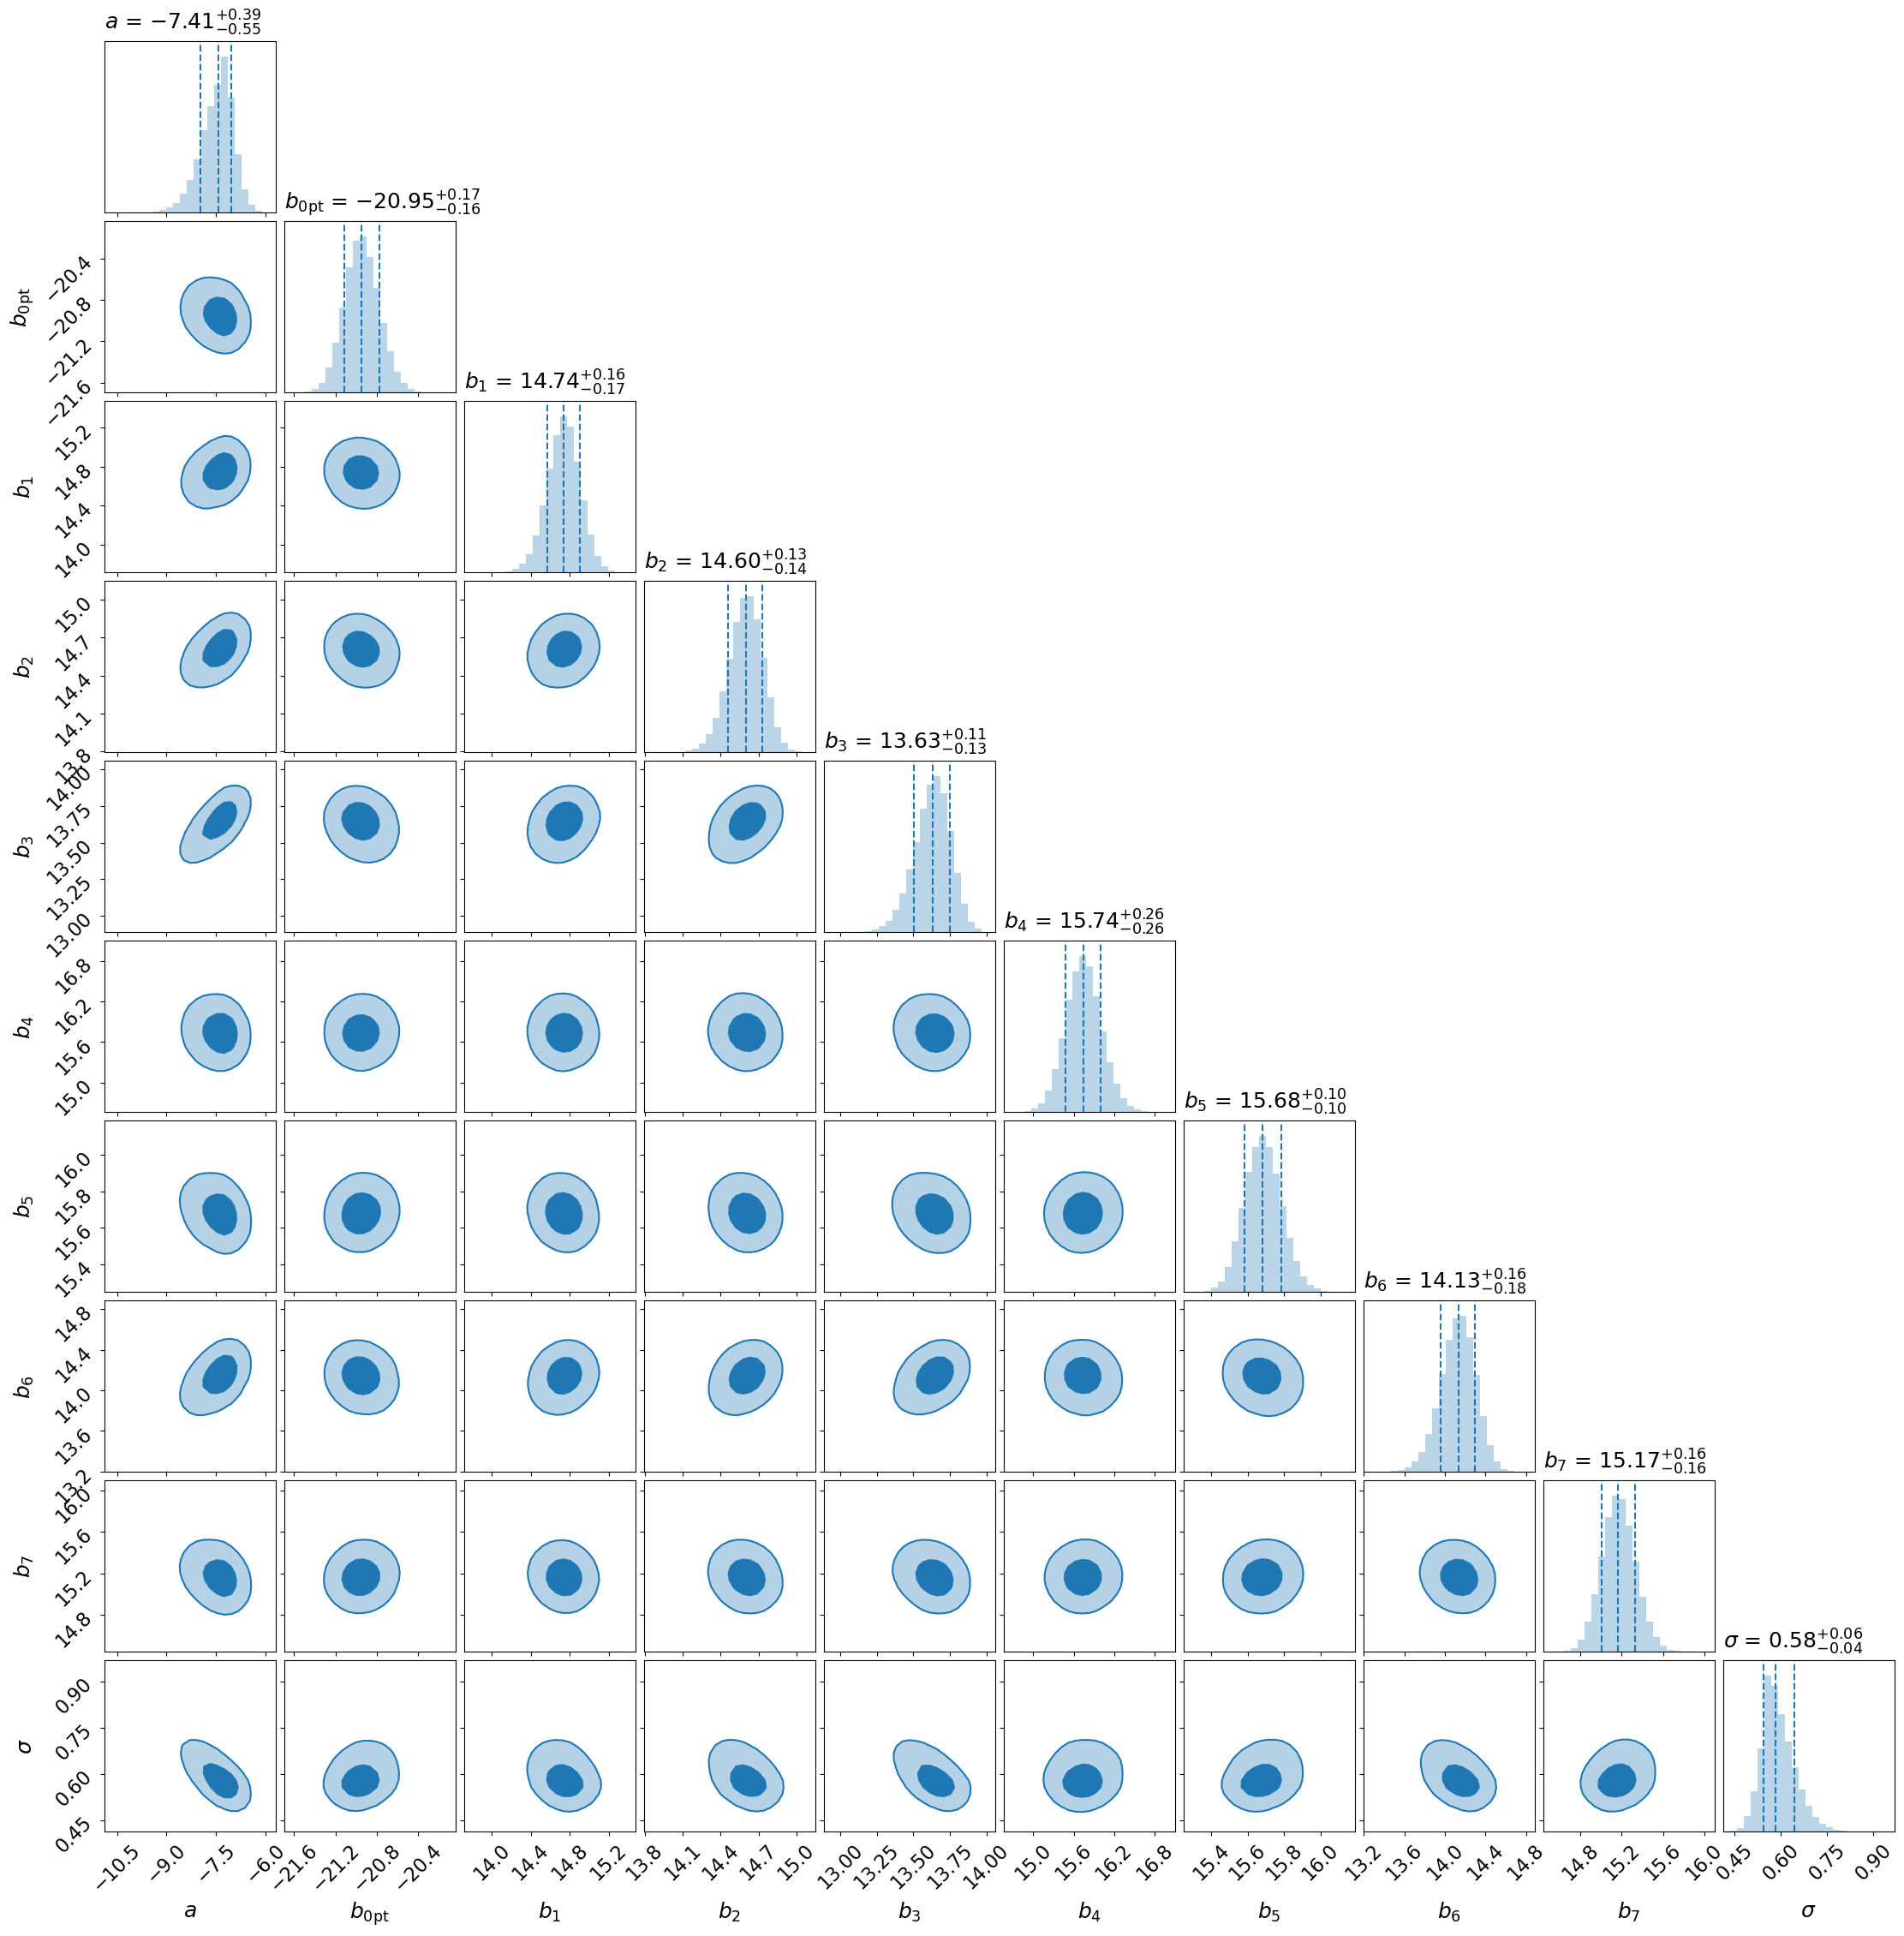

In [57]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_1p5R2t_binaryMLupdated_z0p1_AnthonyUpdates_weightsVmax-1_dVsys_primarySNIa_corner0_20250606.png', 
            dpi=150, 
            facecolor='none');

### Plot the HyperFit Results

In [58]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

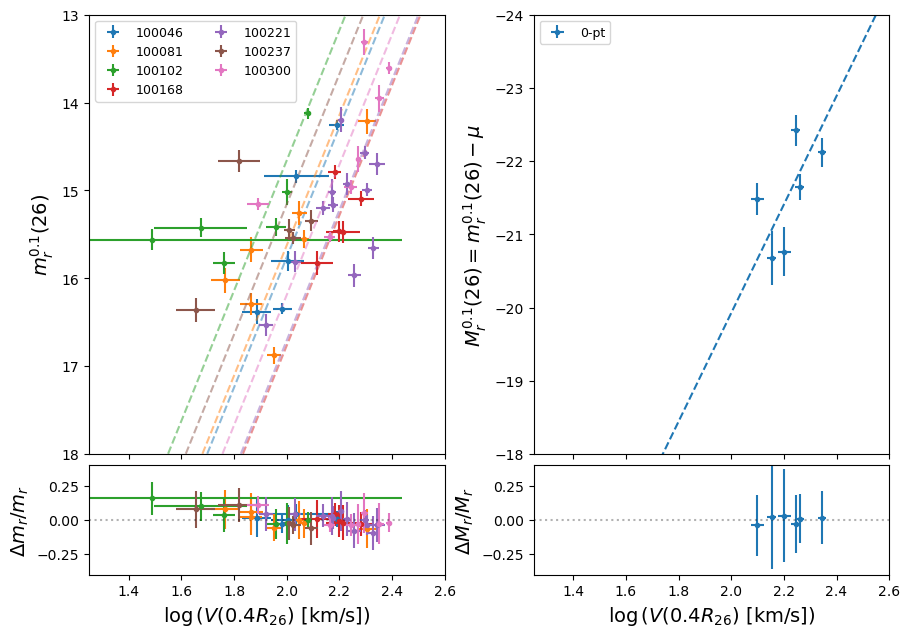

In [59]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_1p5R2t_0pt_binaryMLupdated_z0p1_AnthonyUpdates_weightsVmax-1_dVsys_primarySNIa_fit0_20250606.png', 
            dpi=150, 
            facecolor='none')

In [60]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.97 +/- 0.199


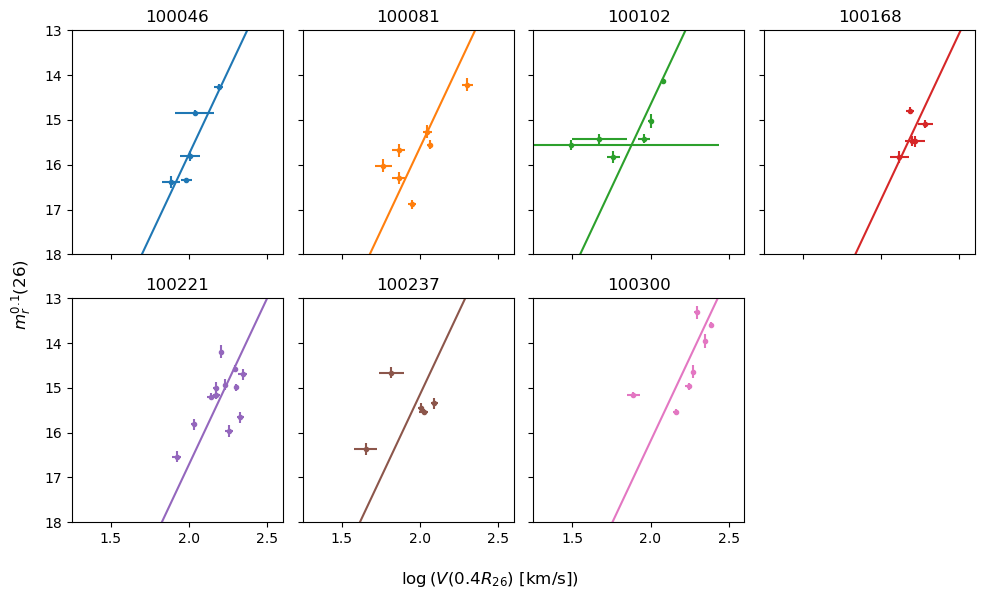

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10,6), tight_layout=True)

color = iter(plt.get_cmap('tab10').colors)
for i in range(m):
    c = next(color)
    
    row = int(i/4)
    col = i%4
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{_cluster_ids[i]}')

# Delete extra axes
fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_1p5R2t_0pt_binaryMLupdated_z0p1_AnthonyUpdates_weightsVmax-1_dVsys_primarySNIa_fit0_20250606.png', 
            dpi=150, 
            facecolor='none')

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [62]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

40.32455071175431 km/s


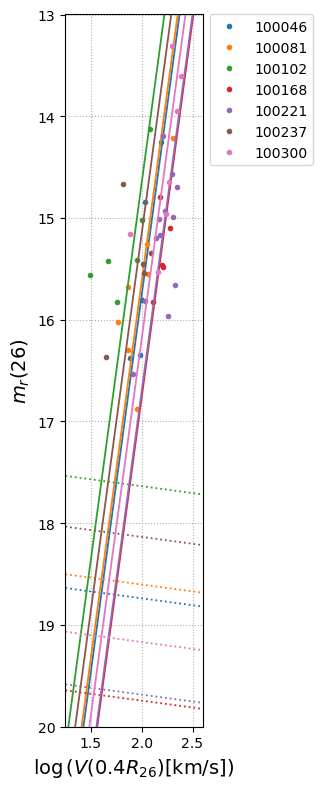

In [63]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V(0.4R_{26}) [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm cluster \perp}
\end{equation}

In [64]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
